In [2]:
# Parameters
notebook_fname = "NN_full_v3_BO_test_9"
data_path = '../01_Dataset_Cleaned/'
model_path = '../04_Model_Saved/'

# Development mode: automatic reloading of modules
%load_ext autoreload
%autoreload 2


# main notebook to train and evaluate the machine learning model


In [3]:
import os
import sys
sys.path.append("..")
sys.path.append("../..")

current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/03_Model_Train_Evaluate_Predict


In [4]:
# basic machine learning libaries
import os
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

# Data processing and plotting
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from tabulate import tabulate

# Bayesian Optimization
import GPyOpt

# Parellisation
from multiprocessing import Pool
from joblib import Parallel, delayed
import concurrent.futures

# Miscellaneous
import importlib
import pickle
import time
import warnings
warnings.filterwarnings("ignore")
# Turn off TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(f'cpu_count: {os.cpu_count()}')

# Data Path
if os.path.isfile(data_path+'LiteratureDataset_Corrosion_YW_v3_processed.xlsx'):
    print(f"Folder '{os.path.abspath(data_path)}' found.")
else:
    print(f"Warning: File '{data_path}' not found!")

# Setting up multiple path for parallel Bayesian Optimization
num_str = notebook_fname.split("_")[-1]  # get the last string after "_"

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")

# model path
model_path_bo = f'{model_path}{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{os.path.abspath(model_path_bo)}' created.")
else:
    print(f"Folder '{os.path.abspath(model_path_bo)}' already exists.")

# Cleaning up previous tensorflow sessions
tf.keras.backend.clear_session()

2023-09-06 15:10:55.781237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 15:10:58.147084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 15:10:58.147257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 15:10:58.147273: W tens

cpu_count: 40
Folder '/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned' found.
bo_ens_num: 9
Folder '/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_9' already exists.


## functionality control


In [69]:
# functionality control of the notebook
Flag_Preprocessing = True
Flag_Training_try = True
Flag_BO_search = True
Flag_Training_BO_best = True
Flag_Evaluation = True
Flag_Prediction = True

# Use GPU or not
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('not using GPU')

not using GPU


## Import hardness and corrosion dataset


In [6]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output = df_H[compo_column], pd.DataFrame(), df_H[
    specific_features_sel_column],  df_H[H_output_column]
(df_C_compo, df_C_specific_testing, df_C_specific_features,
 df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)

## Data preprocessing

**hardness network**

- input (X1): df_H_compo
- input (Y1): df_H_specific_testing
- input (V1): df_H_specific_features
- output(H1): df_H_output

**corrosion network**

- input (X2): df_C_compo
- input (Z2): df_C_specific_testing
- input (W2): df_C_specific_features
- output(C2): df_C_output

### Obtain the MinMaxScaler from normalisation


In [7]:
if Flag_Preprocessing:

    # Prepare data for NN
    dfs = [df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output,
           df_C_compo, df_C_specific_testing, df_C_specific_features, df_C_output]

    # Convert DataFrames to numpy arrays
    inputs_outputs = [np.asarray(df.values) for df in dfs]

    # Define each variable
    (X1, Y1, V1, H1,
     X2, Z2, W2, C2) = inputs_outputs

    # Initialize MinMaxScalers for each data set
    scalers = {
        "compo": MinMaxScaler(),
        "H_specific_testing": MinMaxScaler(),
        "C_specific_testing": MinMaxScaler(),
        "specific_features": MinMaxScaler(),
        "H_output": MinMaxScaler(),
        "C_output": MinMaxScaler()
    }

    # Fit scalers to appropriate data
    scalers["compo"].fit(np.concatenate((X1, X2)))
    if Y1.size != 0:  # if Y1 is empty
        scalers["H_specific_testing"].fit(Y1)
    scalers["C_specific_testing"].fit(Z2)
    scalers["specific_features"].fit(np.concatenate((V1, W2)))
    scalers["H_output"].fit(H1.reshape((-1, 1)))
    scalers["C_output"].fit(C2.reshape((-1, 1)))

    print(scalers)

    # Save the scalers dictionary to a file using pickle
    with open(data_path + 'scalers.pkl', 'wb') as f:
        pickle.dump(scalers, f)

{'compo': MinMaxScaler(), 'H_specific_testing': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_output': MinMaxScaler()}


### RepeatedKFold train-test split

- for hardness: `kfold_with_norm_H`

  - `X1_train_KFold`, `X1_test_KFold`,
  - (empty array)
  - `V1_train_KFold`, `V1_test_KFold`,
  - `H1_train_KFold`, `H1_test_KFold` as lists used in model training

- for corrosion: `kfold_with_norm_C`
  - `X2_train_KFold`, `X2_test_KFold`,
  - `Z2_train_KFold`, `Z2_test_KFold`,
  - `W2_train_KFold`, `W2_test_KFold`,
  - `C2_train_KFold`, `C2_test_KFold` as lists used in model training


In [8]:
if Flag_Preprocessing:

    from utils.preprocessing_kfold_norm import kfold_with_norm

    n_splits, n_repeats, random_state = 6, 2, 42

    # for hardness network
    ([X1_train_KFold, Y1_train_KFold, V1_train_KFold, H1_train_KFold],
     [X1_test_KFold, Y1_test_KFold, V1_test_KFold, H1_test_KFold],
     [X1_train_norm_KFold, Y1_train_norm_KFold,
         V1_train_norm_KFold, H1_train_norm_KFold],
     [X1_test_norm_KFold, Y1_test_norm_KFold, V1_test_norm_KFold, H1_test_norm_KFold]) = kfold_with_norm(X1, Y1, V1, H1,
                                                                                                         scalers["compo"], scalers["H_specific_testing"], scalers[
                                                                                                             "specific_features"], scalers["H_output"],
                                                                                                         n_splits, n_repeats, random_state)

    # for corrosion network
    ([X2_train_KFold, Z2_train_KFold, W2_train_KFold, C2_train_KFold],
     [X2_test_KFold, Z2_test_KFold, W2_test_KFold, C2_test_KFold],
     [X2_train_norm_KFold, Z2_train_norm_KFold,
         W2_train_norm_KFold, C2_train_norm_KFold],
     [X2_test_norm_KFold, Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold]) = kfold_with_norm(X2, Z2, W2, C2,
                                                                                                         scalers["compo"], scalers["C_specific_testing"], scalers[
                                                                                                             "specific_features"], scalers["C_output"],
                                                                                                         n_splits, n_repeats, random_state)

### Plot the histogram of train/test data for each split

- Plotting hardness train/test datasets
- Plotting corrosion train/test datasets


In [10]:
# if Flag_Preprocessing:

#     from utils.preprocessing_kfold_norm import plot_hist_kfold_with_norm

#     # call the function to plot the histograms - hardness network
#     plot_hist_kfold_with_norm(train_data=(X1_train_norm_KFold, Y1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold),
#                               test_data=(X1_test_norm_KFold, Y1_test_norm_KFold, V1_test_norm_KFold,  H1_test_norm_KFold),
#                               x_min=(0, 0, 0, 0),
#                               x_max=(0.2, 0, 1, 1),
#                               axs_title='Hardness network Train/Test Data',
#                               n_splits=6, n_repeats=1, nrows=4)

#     # call the function to plot the histograms - corrosion network
#     plot_hist_kfold_with_norm(train_data=(X2_train_norm_KFold, Z2_train_norm_KFold, W2_train_norm_KFold, C2_train_norm_KFold),
#                               test_data=(X2_test_norm_KFold,  Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold),
#                               x_min=(0, 0, 0, 0),
#                               x_max=(0.2, 1, 1, 1),
#                               axs_title='Corrosion network Train/Test Data',
#                               n_splits=6, n_repeats=1, nrows=4)

## NN architecture, creation, evaluation:

- shared feature NN: NNF
- hardness NN: NNH
- corrosion NN: NNC

class: `MultiTaskNN`

```
         input2-->|
                  |-->[NNH]-->output_H
                  |
 input1-->[NNF]-->|
                  |
                  |-->[NNC]-->output_C
         input3-->|
```


### Using `MultiTaskNN` class for training


In [72]:
if Flag_Training_try:

    from utils.multitask_nn import MultiTaskNN

    start_time = time.time()
    mt_nn = MultiTaskNN(NNF_num_nodes=256, NNF_num_layers=1,
                        NNH_num_nodes=64, NNH_num_layers=4,
                        NNC_num_nodes=64, NNC_num_layers=3,
                        mc_state=True, act='relu',
                        NNF_dropout=0.25, NNH_dropout=0.25, NNC_dropout=0.25,
                        loss_func=tf.keras.metrics.mean_squared_error,
                        learning_rate_H=0.001, learning_rate_C=0.001,
                        batch_size_H=32,
                        N_epochs_local=1, total_epochs=10,
                        model_save_flag=True, model_path_bo=model_path_bo,
                        NNH_model_name='NNH_model_RepeatedKFold_{}',
                        NNC_model_name='NNC_model_RepeatedKFold_{}')

    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    # train_loss/val_loss: training/validation loss history
    # score_loss/score_r2: evaluated loss score/R2 score

    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                               X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                               k_folds, n_CVrepeats)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


2023-09-06 22:31:16.435068: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 22:31:16.435175: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-06 22:31:16.435247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws14): /proc/driver/nvidia/version does not exist
2023-09-06 22:31:16.436254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 

saved model:  NNH_model_RepeatedKFold_9_mc.h5
saved model:  NNC_model_RepeatedKFold_9_mc.h5
saved model:  NNH_model_RepeatedKFold_2_mc.h5
saved model:  NNC_model_RepeatedKFold_2_mc.h5
saved model:  NNH_model_RepeatedKFold_8_mc.h5
saved model:  NNC_model_RepeatedKFold_8_mc.h5
saved model:  NNH_model_RepeatedKFold_10_mc.h5
saved model:  NNC_model_RepeatedKFold_10_mc.h5
saved model:  NNH_model_RepeatedKFold_12_mc.h5
saved model:  NNC_model_RepeatedKFold_12_mc.h5
saved model:  NNH_model_RepeatedKFold_5_mc.h5
saved model: saved model:   NNC_model_RepeatedKFold_5_mc.h5
NNH_model_RepeatedKFold_11_mc.h5
saved model:  NNC_model_RepeatedKFold_11_mc.h5
saved model:  NNH_model_RepeatedKFold_7_mc.h5
saved model:  NNC_model_RepeatedKFold_7_mc.h5
saved model:  NNH_model_RepeatedKFold_4_mc.h5
saved model:  NNC_model_RepeatedKFold_4_mc.h5
saved model:  NNH_model_RepeatedKFold_3_mc.h5
saved model:  NNC_model_RepeatedKFold_3_mc.h5
saved model:  NNH_model_RepeatedKFold_6_mc.h5
saved model:  NNC_model_Repe

### Training quality for NNH_model and NNC_model


In [73]:
if Flag_Training_try:
    # training results by score_loss
    # print([f'{x:.4f}' for x in score_loss_H])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_H[i][-1]])
    print(
        f"score_loss_H: {np.mean(score_loss_H):.4f} ({np.std(score_loss_H):.4f})")

    # print([f'{x:.4f}' for x in score_loss_C])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_C[i][-1]])
    print(
        f"score_loss_C: {np.mean(score_loss_C):.4f} ({np.std(score_loss_C):.4f})")

    # training results by score_r2
    # print([f'{x:.4f}' for x in score_r2_H])
    print(
        f"score_r2_H:   {np.mean(score_r2_H):.4f} ({np.std(score_r2_H):.4f})")

    # print([f'{x:.4f}' for x in score_r2_C])
    print(f"score_r2_C: {np.mean(score_r2_C):.4f} ({np.std(score_r2_C):.4f})")

    print(f"score_r2_HC: {np.mean([score_r2_H, score_r2_C]):.4f}")

score_loss_H: 0.0176 (0.0016)
score_loss_C: 0.0141 (0.0021)
score_r2_H:   0.5395 (0.0353)
score_r2_C: 0.5578 (0.0593)
score_r2_HC: 0.5486


### Plot the loss history


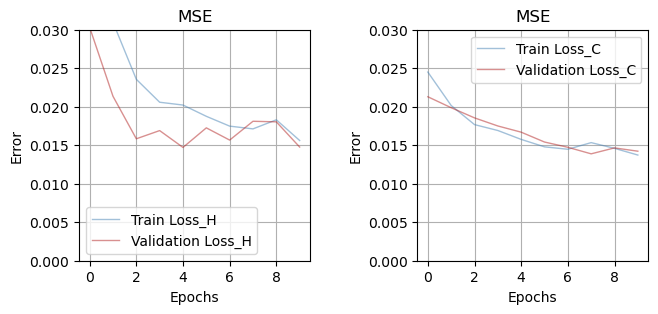

In [74]:
if Flag_Training_try:
    mt_nn.plot_losses(train_loss_H, val_loss_H,
                      train_loss_C, val_loss_C, k_folds=6, n_CVrepeats=2, index=0)

## Bayesian Hyperparameter Optimisation

class: `BO_hyper_objective`


### Define the search domain


In [55]:
if Flag_BO_search:
    # Define the search space for hyperparameters

    # loss_encoder == 0: mean_squared_error
    # loss_encoder == 1: mean_absolute_error

    search_hyper_space = [{'name': 'NNF_num_nodes',   'type': 'discrete',  'domain': (32, 64, 128, 256)},  # 0: NNF_num_nodes
                          {'name': 'NNF_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3, 4, 5)},  # 1: NNF_num_layers
                          {'name': 'NNH_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 2: NNH_num_nodes
                          {'name': 'NNH_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 3: NNH_num_layers
                          {'name': 'NNC_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 4: NNC_num_nodes
                          {'name': 'NNC_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 5: NNC_num_layers
                          {'name': 'learning_rate_H', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 9: learning_rate_H
                          {'name': 'learning_rate_C', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 10: learning_rate_C
                          {'name': 'batch_size_H',    'type': 'discrete',
                           'domain': (16, 32, 64)},        # 11: batch_size_H
                          {'name': 'N_epochs_local',  'type': 'discrete',  'domain': (1, 2, 3)}]  # 12: N_epochs_global

    fixed_hyper_space = [{'name': 'NNF_dropout',     'type': 'continuous',
                          'domain': (0.1)},            # 6: NNF_dropout
                         {'name': 'NNH_NNC_dropout', 'type': 'continuous',
                          'domain': (0.1)},            # 7: NNH_NNC_dropout
                         {'name': 'loss_encoder',      'type': 'discrete',
                          'domain': (0)}]               # 8: loss_encoder

    search_hyper_names = [entry['name'] for entry in search_hyper_space]
    fixed_hyper_names = [entry['name'] for entry in fixed_hyper_space]
    all_hyper_names = ['NNF_num_nodes', 'NNF_num_layers', 'NNH_num_nodes', 'NNH_num_layers', 'NNC_num_nodes', 'NNC_num_layers',
                       'NNF_dropout', 'NNH_NNC_dropout',  'loss_encoder', 'learning_rate_H',  'learning_rate_C',   'batch_size_H', 'N_epochs_local']

### BO hyperparameter optimisation


In [76]:
if Flag_BO_search:
    from utils.BO_hyper_objective import BayesianOptimizationObjective

    start_time = time.time()

    # Set up the optimizer
    bo = None
    bo_iteration = 0
    np.random.seed(bo_ens_num)

    # Configuration settings for the model being optimized
    total_epochs = 10
    n_initial_points, n_iterations = 1, 1

    mc_state, act = True, 'relu'
    model_save_flag = False
    NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}', 'NNC_model_RepeatedKFold_{}'
    k_folds, n_CVrepeats = 6, 2
    score_r2_HC_list, score_loss_HC_list, score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list = [], [], [], [], [], []

    # Instantiate the objective function class for Bayesian Optimization
    bo_obj = BayesianOptimizationObjective(
        bo_ens_num, model_path_bo, all_hyper_names, search_hyper_names)

    # Set up and configure Bayesian Optimization using GPyOpt
    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: bo_obj.BO_NNF_NNH_NNC_objective(x, fixed_hyper_space, search_hyper_names, fixed_hyper_names,
                                                                                         n_initial_points, n_iterations,
                                                                                         mc_state, act,
                                                                                         total_epochs,
                                                                                         model_save_flag, model_path_bo,
                                                                                         NNH_model_name, NNC_model_name,
                                                                                         X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                                         X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                                         k_folds, n_CVrepeats,
                                                                                         score_r2_HC_list, score_loss_HC_list,
                                                                                         score_r2_H_list, score_r2_C_list,
                                                                                         score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                             domain=search_hyper_space,
                                             model_type='GP',
                                             initial_design_numdata=n_initial_points,
                                             init_design_type='random',
                                             acquisition_type='EI',
                                             acquisition_optimizer_type='lbfgs',
                                             maximize=True)

    # Start the optimization for the given number of iterations
    bo.run_optimization(max_iter=n_iterations)

    # Print the best hyperparameters and their corresponding objective value
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)

    # Calculate and display the elapsed time for the optimization
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

2023-09-06 22:44:34.058146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 22:44:34.058213: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-06 22:44:34.058255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws14): /proc/driver/nvidia/version does not exist
2023-09-06 22:44:34.058788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 

Iteration: 1/2


2023-09-06 22:45:01.919205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 22:45:01.919208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 22:45:01.919279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-06 22:45:01.919279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-06 22:45:01.919336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 2/2
Best hyperparameters: 64.0000, 3.0000, 32.0000, 2.0000, 64.0000, 3.0000, 0.0004, 0.0003, 16.0000, 1.0000
Best objective value: 0.4582592844117981
Time taken:  56 seconds


### Save the BO hypertable


In [77]:
if Flag_BO_search:

    # update the hypertable
    bo_obj.update_hypertable(fixed_hyper_space, bo,
                             score_r2_HC_list, score_loss_HC_list,
                             score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list)

    # Save the sorted data to an Excel file
    bo_obj.hypertable.to_excel(model_path_bo +
                               f"hypertable_{notebook_fname}.xlsx", index=False)

    # sort the list start from the best results
    hypertable_sort = bo_obj.hypertable.sort_values(
        by=['score_r2_HC'], ascending=False, ignore_index=True)

    display(hypertable_sort.head())

    # Save the sorted data to an Excel file
    hypertable_sort.to_excel(model_path_bo +
                             f"hypertable_sort_{notebook_fname}.xlsx", index=False)

score_r2_HC  score_r2_HC_best  score_loss_HC  score_r2_H  score_r2_C  \
0     0.458259          0.458259       0.018363    0.474137    0.442382   
1     0.388804          0.388804       0.020148    0.243374    0.534233   

   score_loss_H  score_loss_C  NNF_num_nodes  NNF_num_layers  NNH_num_nodes  \
0      0.019604      0.017123           64.0             3.0           32.0   
1      0.026221      0.014075          128.0             5.0          128.0   

   NNH_num_layers  NNC_num_nodes  NNC_num_layers  NNF_dropout  \
0             2.0           64.0             3.0          0.1   
1             2.0          128.0             1.0          0.1   

   NNH_NNC_dropout  loss_encoder  learning_rate_H  learning_rate_C  \
0              0.1             0         0.000365         0.000310   
1              0.1             0         0.000105         0.000451   

   batch_size_H  N_epochs_local  
0          16.0             1.0  
1          64.0             2.0

### Plotting the BO process


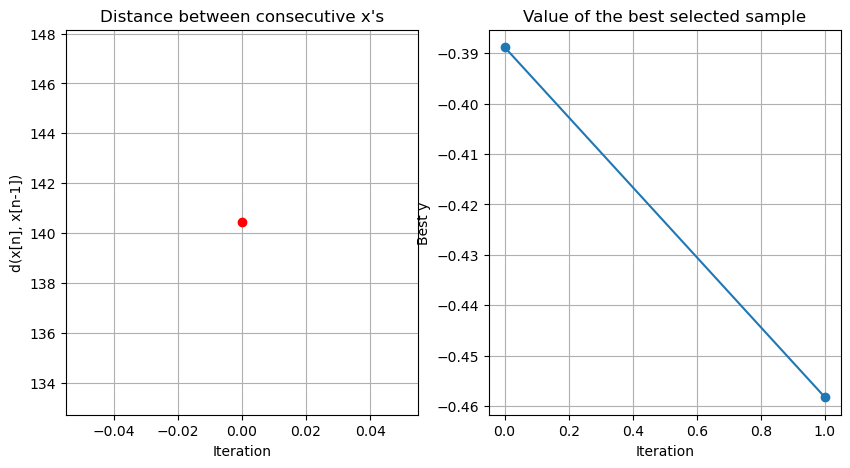

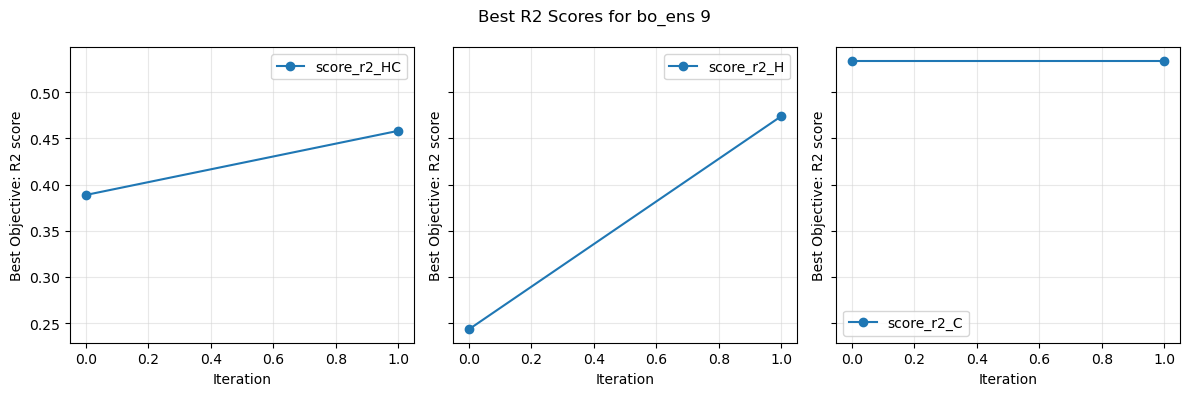

In [78]:
if Flag_BO_search:
    # plot the convergence
    bo.plot_convergence()

    bo_obj.plot_best_r2_score()

## Model training: using best BO hyperparameters


In [ ]:
def create_empty_arrays(arr_list):
        return [np.empty((arr.shape[0], 0)) for arr in arr_list]

    datasets = [Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold,
                Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold]

    Y1_train_empty, Y1_test_empty, V1_train_empty, V1_test_empty, \
    Z2_train_empty, Z2_test_empty, W2_train_empty, W2_test_empty = map(create_empty_arrays, datasets)

    # remember that V1 and W1 needs to have the same shape all the time
    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_empty, Y1_test_empty, V1_train_empty, V1_test_empty, H1_train_norm_KFold, H1_test_norm_KFold,
                                                               X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_empty, Z2_test_empty, W2_train_empty, W2_test_empty, C2_train_norm_KFold, C2_test_norm_KFold,
                                                               k_folds, n_CVrepeats)

In [79]:
if Flag_Training_BO_best:

    import tensorflow as tf
    import time
    import concurrent.futures
    from utils.multitask_nn import MultiTaskNN

    def get_hyperparameter(param_name):
        return hypertable_sort.loc[0, param_name]

    def create_multi_task_nn(mc_state, total_epochs):
        params = {
            'NNF_num_nodes': int(get_hyperparameter('NNF_num_nodes')),
            'NNF_num_layers': int(get_hyperparameter('NNF_num_layers')),
            'NNH_num_nodes': int(get_hyperparameter('NNH_num_nodes')),
            'NNH_num_layers': int(get_hyperparameter('NNH_num_layers')),
            'NNC_num_nodes': int(get_hyperparameter('NNC_num_nodes')),
            'NNC_num_layers': int(get_hyperparameter('NNC_num_layers')),
            'mc_state': mc_state,
            'act': 'relu',
            'NNF_dropout': get_hyperparameter('NNF_dropout'),
            'NNH_dropout': get_hyperparameter('NNH_NNC_dropout'),
            'NNC_dropout': get_hyperparameter('NNH_NNC_dropout'),
            'loss_func': loss_func,
            'learning_rate_H': get_hyperparameter('learning_rate_H'),
            'learning_rate_C': get_hyperparameter('learning_rate_C'),
            'batch_size_H': int(get_hyperparameter('batch_size_H')),
            'N_epochs_local': int(get_hyperparameter('N_epochs_local')),
            'total_epochs': total_epochs,
            'model_save_flag': True,
            'model_path_bo': model_path_bo,
            'NNH_model_name': 'NNH_model_RepeatedKFold_{}',
            'NNC_model_name': 'NNC_model_RepeatedKFold_{}'
        }

        return MultiTaskNN(**params)

    start_time = time.time()

    # loading the best BO hyperparameters
    hypertable_sort = pd.read_excel(
        model_path_bo + f"hypertable_sort_{notebook_fname}.xlsx")
    display(hypertable_sort.head(1))

    loss_encoders = {
        0: tf.keras.metrics.mean_squared_error,
        1: tf.keras.metrics.mean_absolute_error
    }
    loss_encoder = int(get_hyperparameter('loss_encoder'))
    loss_func = loss_encoders.get(loss_encoder)
    if not loss_func:
        raise ValueError(f"Invalid loss function '{loss_encoder}' ")

    k_folds, n_CVrepeats = 6, 2

    mt_nn_BObest_mc = create_multi_task_nn(mc_state=True, total_epochs=10)
    mt_nn_BObest = create_multi_task_nn(mc_state=False, total_epochs=10)

    # Helper function to evaluate the model
    def evaluate_model(model):
        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats
        )

== == == == =

I will want to train 4 types of models here:
1 and 2 are the existing ones
and I will remove features and use the simpliest model for XAI
== == == ==

  # Using ProcessPoolExecutor to run in parallel
  results = []
   with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluate_model, mt_nn_BObest_mc),
                   executor.submit(evaluate_model, mt_nn_BObest)]

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            results.append(result)

    # Unpack results as needed
    (train_loss_H_mc, train_loss_C_mc, val_loss_H_mc,
     val_loss_C_mc, _, _, _, _) = results[0]
    (train_loss_H, train_loss_C, val_loss_H,
     val_loss_C, _, _, _, _) = results[1]

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


score_r2_HC  score_r2_HC_best  score_loss_HC  score_r2_H  score_r2_C  \
0     0.458259          0.458259       0.018363    0.474137    0.442382   

   score_loss_H  score_loss_C  NNF_num_nodes  NNF_num_layers  NNH_num_nodes  \
0      0.019604      0.017123             64               3             32   

   NNH_num_layers  NNC_num_nodes  NNC_num_layers  NNF_dropout  \
0               2             64               3          0.1   

   NNH_NNC_dropout  loss_encoder  learning_rate_H  learning_rate_C  \
0              0.1             0         0.000365          0.00031   

   batch_size_H  N_epochs_local  
0            16               1

2023-09-06 22:49:11.884845: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 22:49:11.885012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-06 22:49:11.885069: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-06 22:49:11.885555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws14): /proc/driver/nvidia/version does not exist
2023-09-06 22:49:11.885546: W tensorflow/compiler/xla/

saved model:  NNH_model_RepeatedKFold_5.h5
saved model:  NNC_model_RepeatedKFold_5.h5
saved model:  NNH_model_RepeatedKFold_9.h5
saved model:  NNC_model_RepeatedKFold_9.h5
saved model:  NNH_model_RepeatedKFold_12_mc.h5
saved model:  NNC_model_RepeatedKFold_12_mc.h5
saved model:  NNH_model_RepeatedKFold_8.h5
saved model:  NNC_model_RepeatedKFold_8.h5
saved model:  NNH_model_RepeatedKFold_5_mc.h5
saved model:  NNC_model_RepeatedKFold_5_mc.h5
saved model:  NNH_model_RepeatedKFold_2_mc.h5
saved model:  NNC_model_RepeatedKFold_2_mc.h5
saved model:  NNH_model_RepeatedKFold_12.h5
saved model:  NNC_model_RepeatedKFold_12.h5
saved model:  NNH_model_RepeatedKFold_7_mc.h5
saved model:  NNC_model_RepeatedKFold_7_mc.h5
saved model:  NNH_model_RepeatedKFold_11_mc.h5
saved model:  NNC_model_RepeatedKFold_11_mc.h5
saved model:  NNH_model_RepeatedKFold_3_mc.h5
saved model:  NNC_model_RepeatedKFold_3_mc.h5
saved model:  NNH_model_RepeatedKFold_1.h5
saved model:  NNC_model_RepeatedKFold_1.h5
saved model:

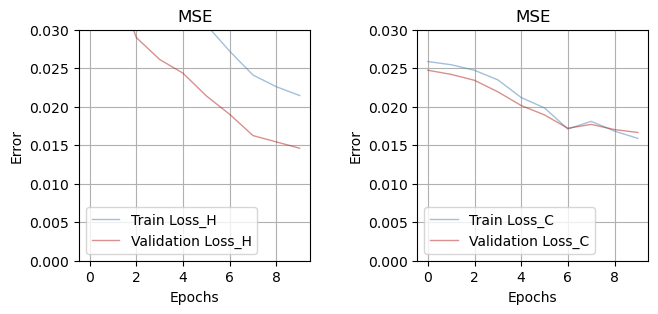

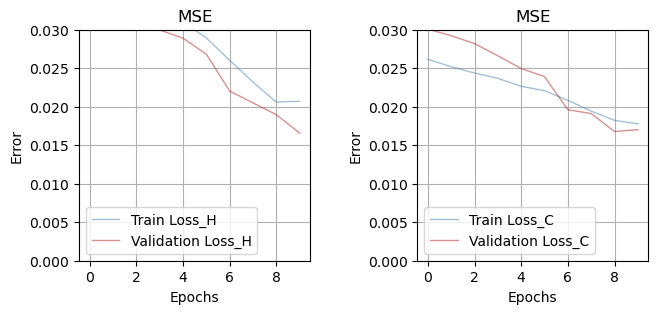

In [82]:
if Flag_Training_BO_best:

    mt_nn_BObest_mc.plot_losses(train_loss_H_mc, val_loss_H_mc, train_loss_C_mc,
                                val_loss_C_mc, k_folds=6, n_CVrepeats=2, index=0)  # index points to bootstrap

    mt_nn_BObest.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                             val_loss_C, k_folds=6, n_CVrepeats=2, index=0)  # index points to bootstrap

## Evaluate the training results

- Show the model.h5 files in this directory
- Load scalers


In [94]:
import pickle
from utils.postprocessing_evalutation import display_saved_models

print(os.path.abspath(model_path_bo))

NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_', 'NNC_model_RepeatedKFold_'

display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name, mc_state=True)
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name, mc_state=False)

# Load the scalers dictionary from a file using pickle
with open(data_path + 'scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    print("")
print(scalers)


/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_9

NNH_model_mc                      NNC_model_mc
--------------------------------  --------------------------------
NNH_model_RepeatedKFold_1_mc.h5   NNC_model_RepeatedKFold_1_mc.h5
NNH_model_RepeatedKFold_2_mc.h5   NNC_model_RepeatedKFold_2_mc.h5
NNH_model_RepeatedKFold_3_mc.h5   NNC_model_RepeatedKFold_3_mc.h5
NNH_model_RepeatedKFold_4_mc.h5   NNC_model_RepeatedKFold_4_mc.h5
NNH_model_RepeatedKFold_5_mc.h5   NNC_model_RepeatedKFold_5_mc.h5
NNH_model_RepeatedKFold_6_mc.h5   NNC_model_RepeatedKFold_6_mc.h5
NNH_model_RepeatedKFold_7_mc.h5   NNC_model_RepeatedKFold_7_mc.h5
NNH_model_RepeatedKFold_8_mc.h5   NNC_model_RepeatedKFold_8_mc.h5
NNH_model_RepeatedKFold_9_mc.h5   NNC_model_RepeatedKFold_9_mc.h5
NNH_model_RepeatedKFold_10_mc.h5  NNC_model_RepeatedKFold_10_mc.h5
NNH_model_RepeatedKFold_11_mc.h5  NNC_model_RepeatedKFold_11_mc.h5
NNH_model_RepeatedKFold_12_mc.

### Plot true vs predictions (test data) for each RepeatedKFold


2023-09-06 23:17:46.044964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 23:17:46.044961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 23:17:46.045024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

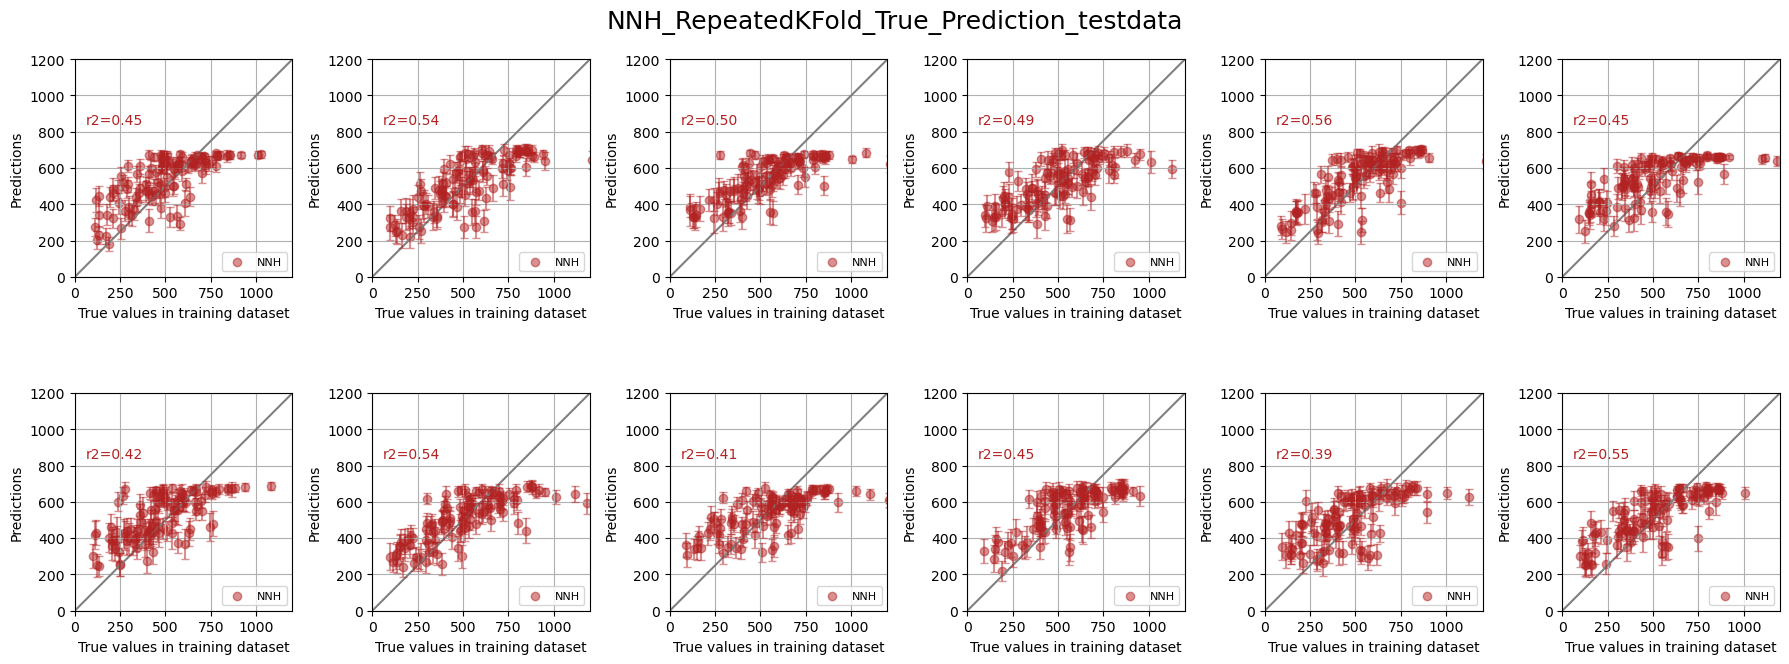

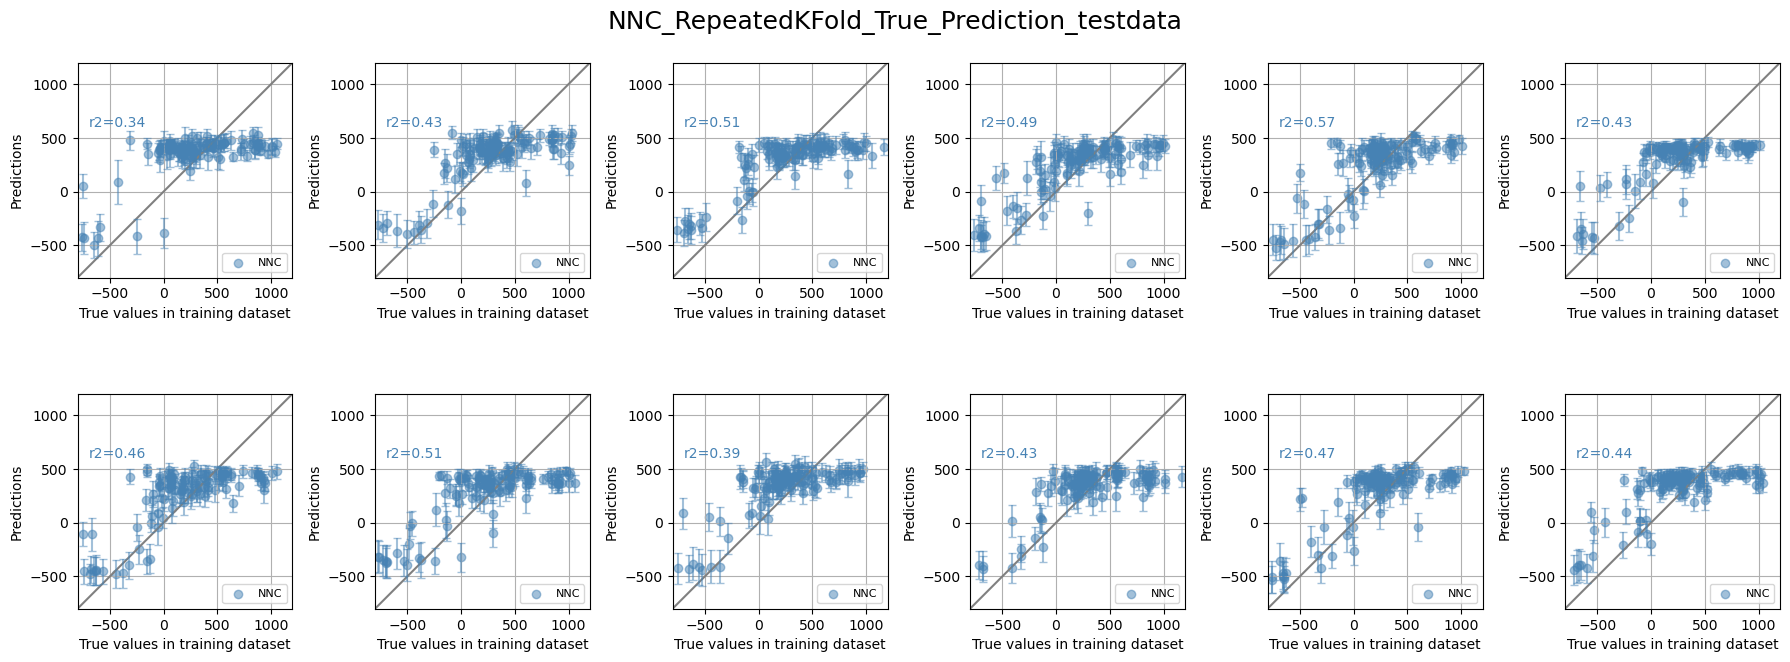

In [95]:
if Flag_Evaluation:

    from utils.postprocessing_evalutation import predict_bootstrap, plot_test_true_vs_pred

    NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}_mc.h5', 'NNC_model_RepeatedKFold_{}_mc.h5'
    k_folds, n_CVrepeats, mc_repeat = 6, 2, 50

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  X1_test_KFold, [], V1_test_KFold,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  X2_test_KFold, Z2_test_KFold, W2_test_KFold,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

    H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
    C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()

    plot_test_true_vs_pred(k_folds, n_CVrepeats, H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std,
                           [0, 1200], 'NNH', 'firebrick', model_path_bo)

    plot_test_true_vs_pred(k_folds, n_CVrepeats, C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std,
                           [-800, 1200], 'NNC', 'steelblue', model_path_bo)

### Plot true vs predictions (full dataset) including all model ensembles


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

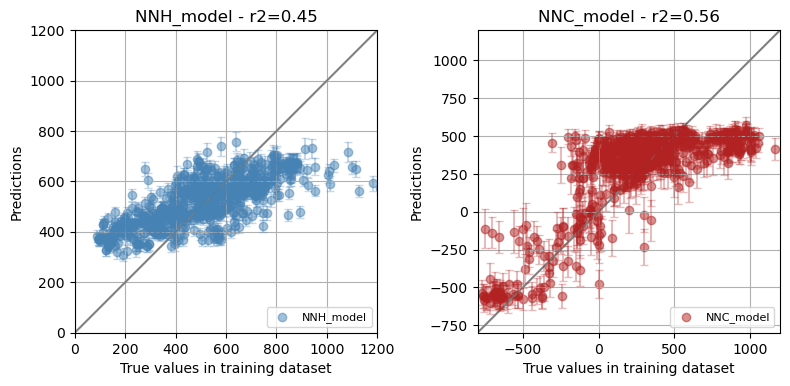

In [ ]:
if Flag_Evaluation:

    from utils.postprocessing_evalutation import predict_bootstrap, plot_full_true_vs_pred

    X1_list, Y1_list, V1_list = [X1]*k_folds * \
        n_CVrepeats, [], [V1]*k_folds*n_CVrepeats
    X2_list, Z2_list, W2_list = [
        X2]*k_folds*n_CVrepeats, [Z2]*k_folds*n_CVrepeats, [W2]*k_folds*n_CVrepeats

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  X1_list, Y1_list, V1_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  X2_list, Z2_list, W2_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

    H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
    C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()

    plot_full_true_vs_pred([H1, C2], [H1_pred_X1_stack, C2_pred_X2_stack],
                           model_path_bo, lims=[[0, 1200], [-800, 1200]])

## Predict based on new data inputs


### Coordinates for PVD alloy representation


In [ ]:
if Flag_Prediction:
    # load the wafer-coordinates
    df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
    coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
    coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
    index_PVD_x_y = df_PVD_x_y.index.values+1

### Make predictions for new alloys

- NiCrCoVFe_KW99
- NiCrMoTiFe_KW131


Processing:   0%|          | 0/2 [00:00<?, ?it/s]

['Ni', 'Cr', 'Co', 'V', 'Fe']
NiCrCoVFe_KW99


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

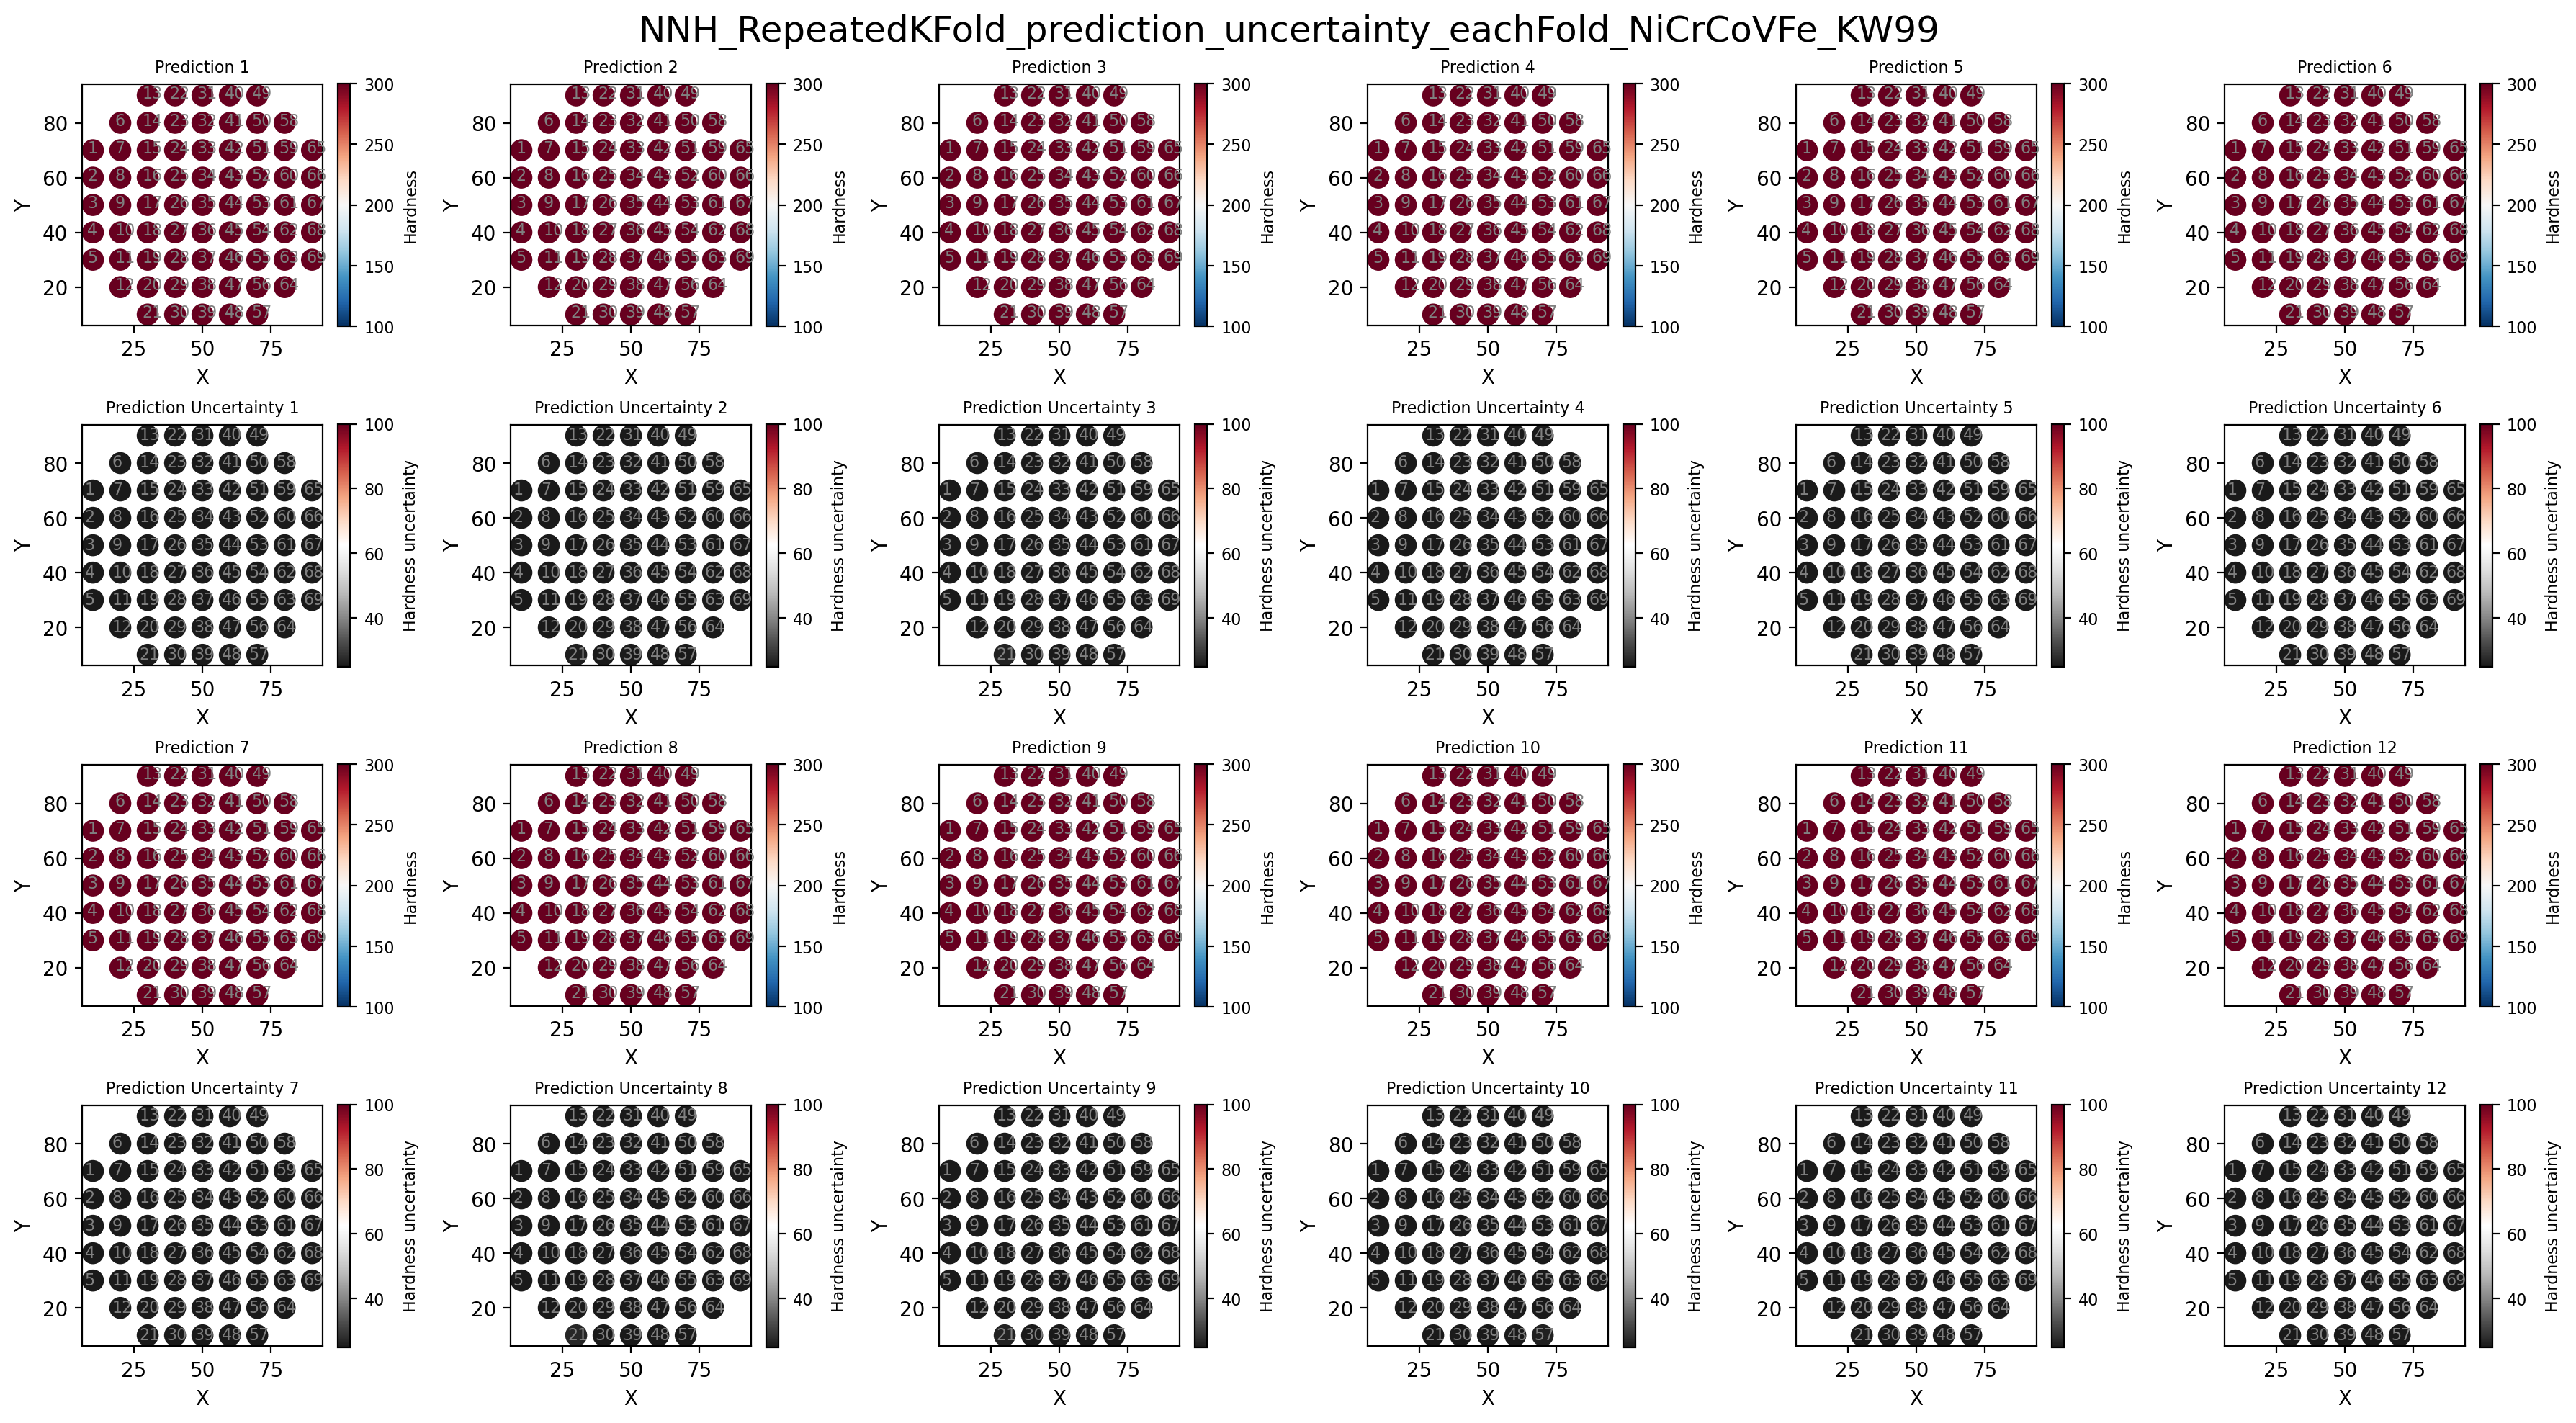

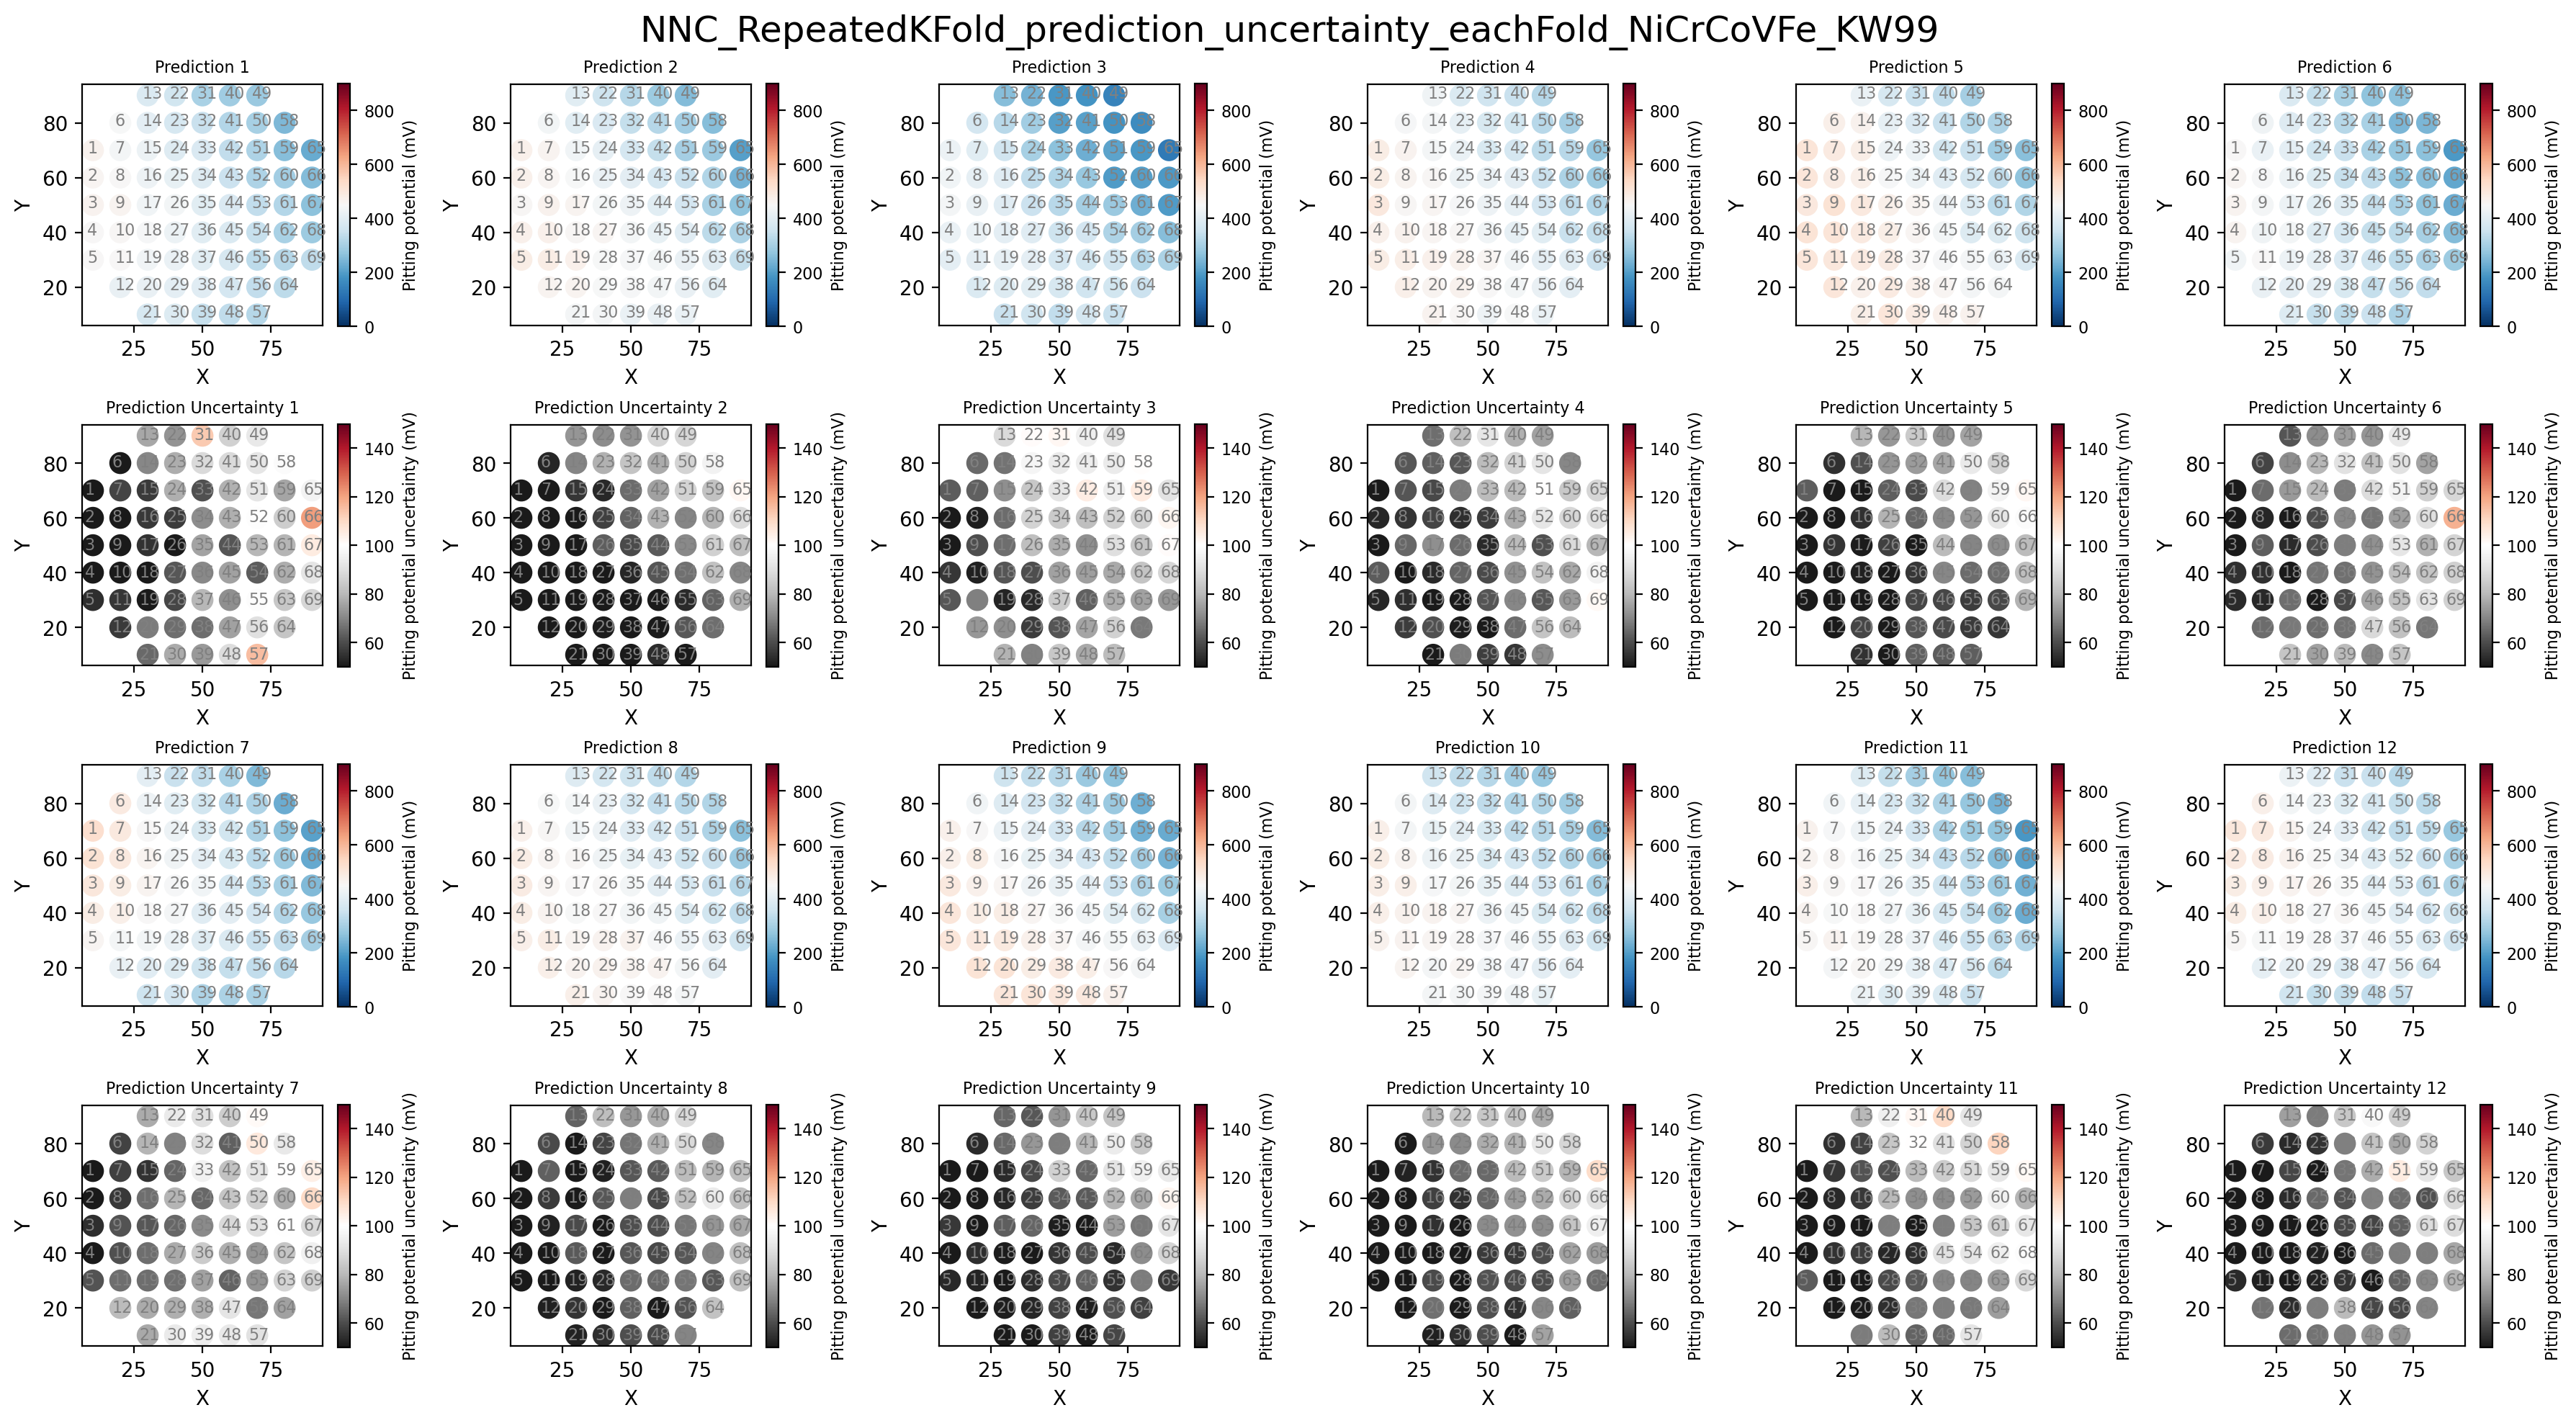

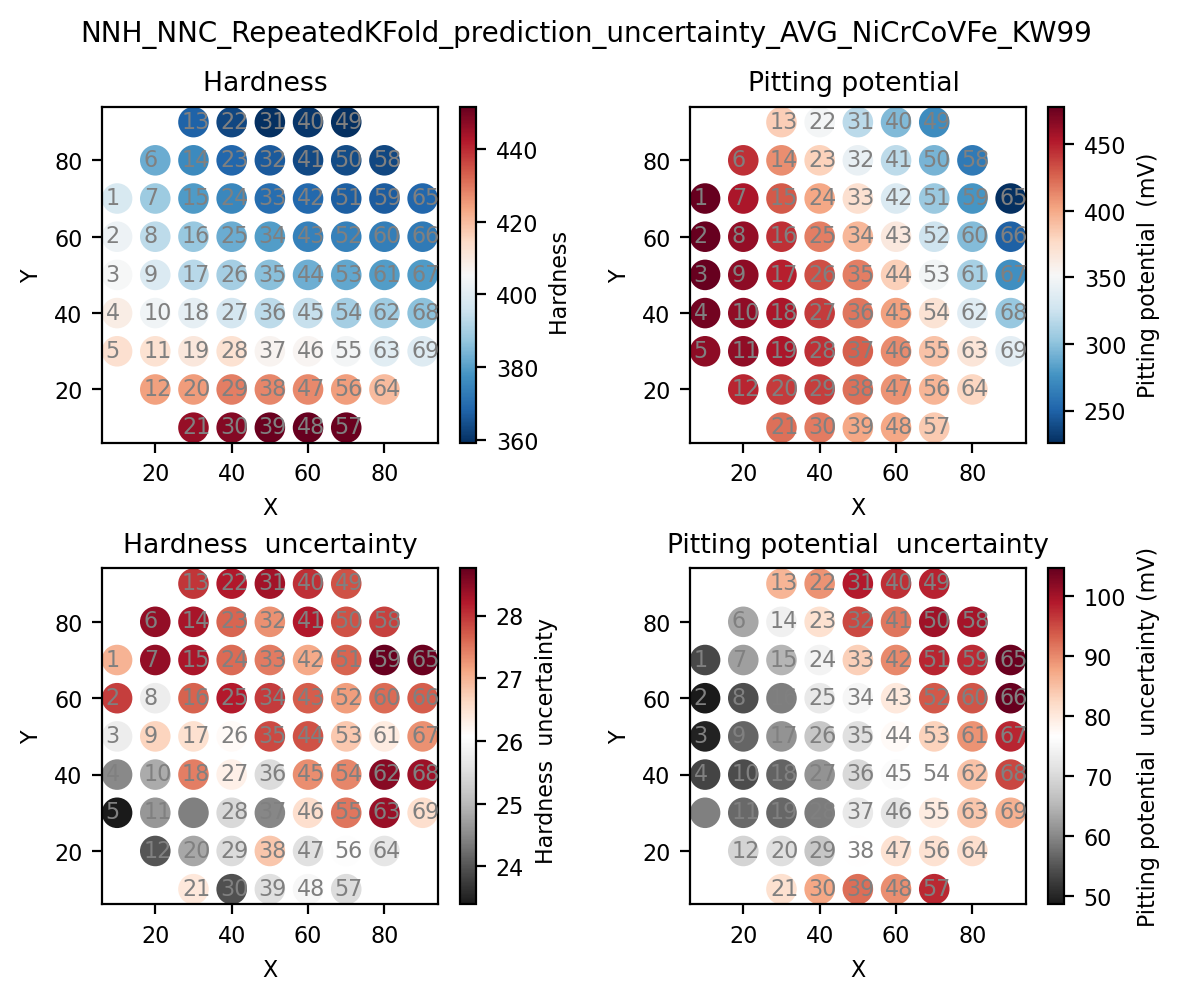

Processing:  50%|█████     | 1/2 [00:53<00:53, 53.16s/it]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiCrMoTiFe_KW131


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

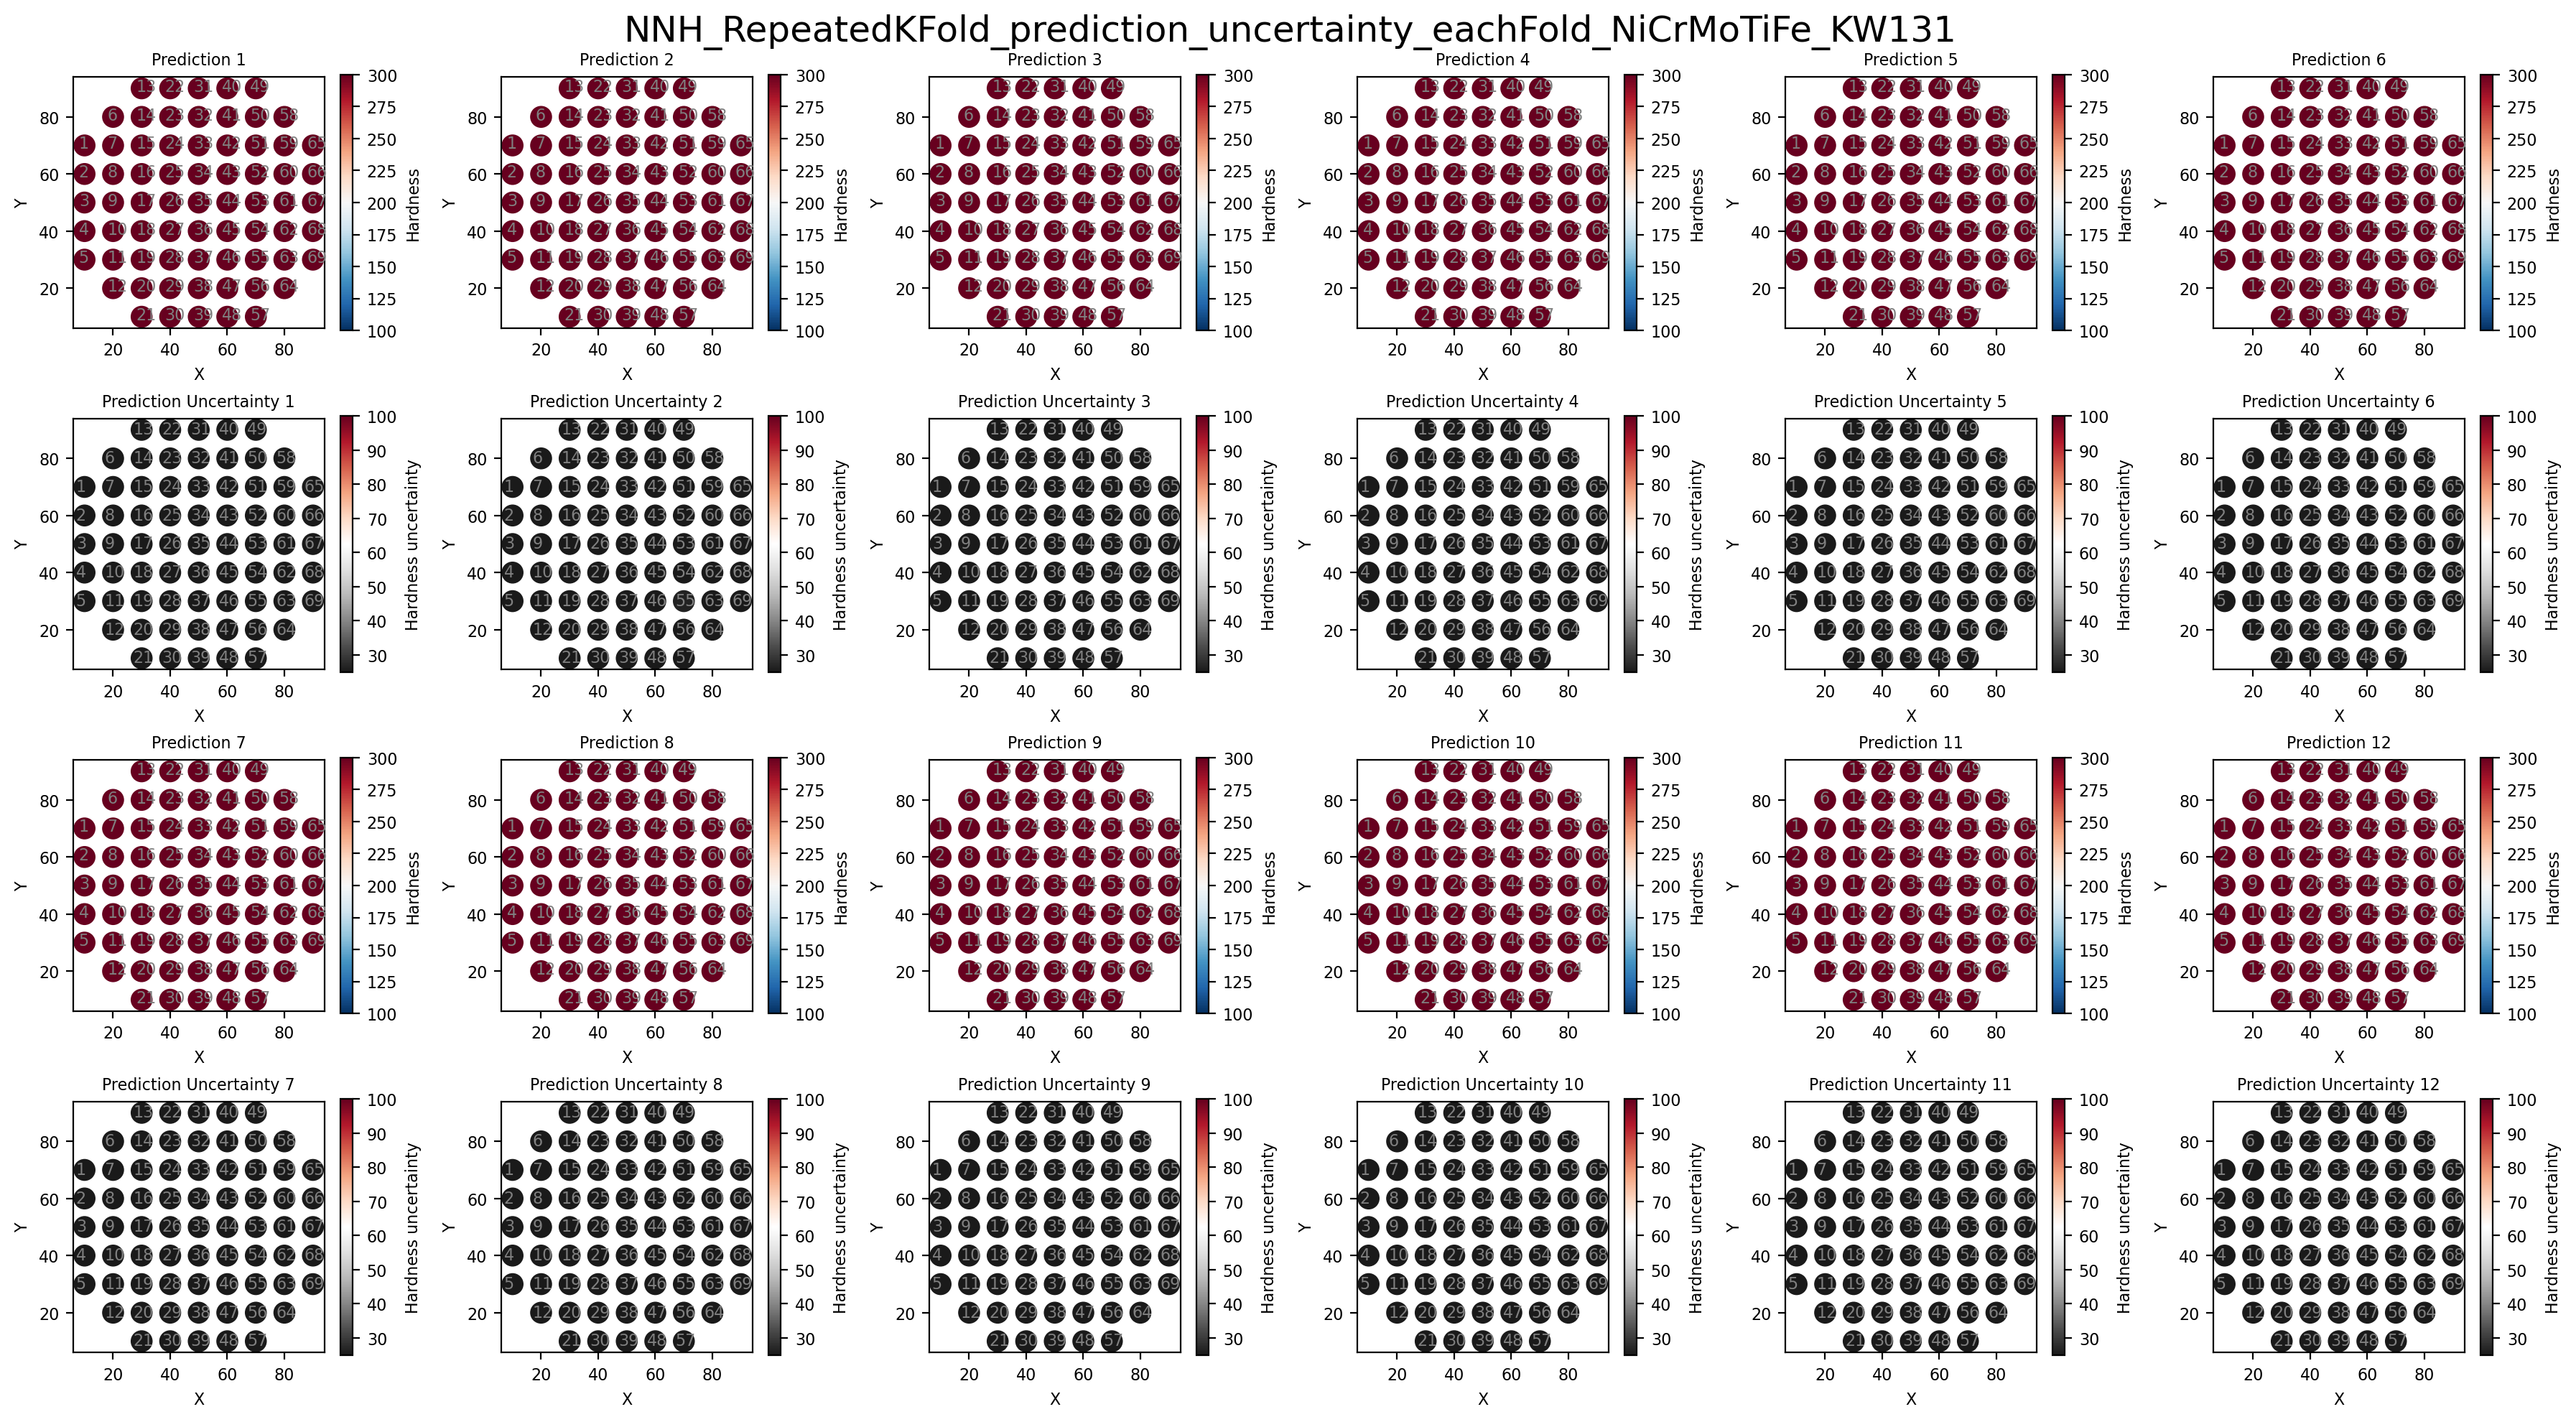

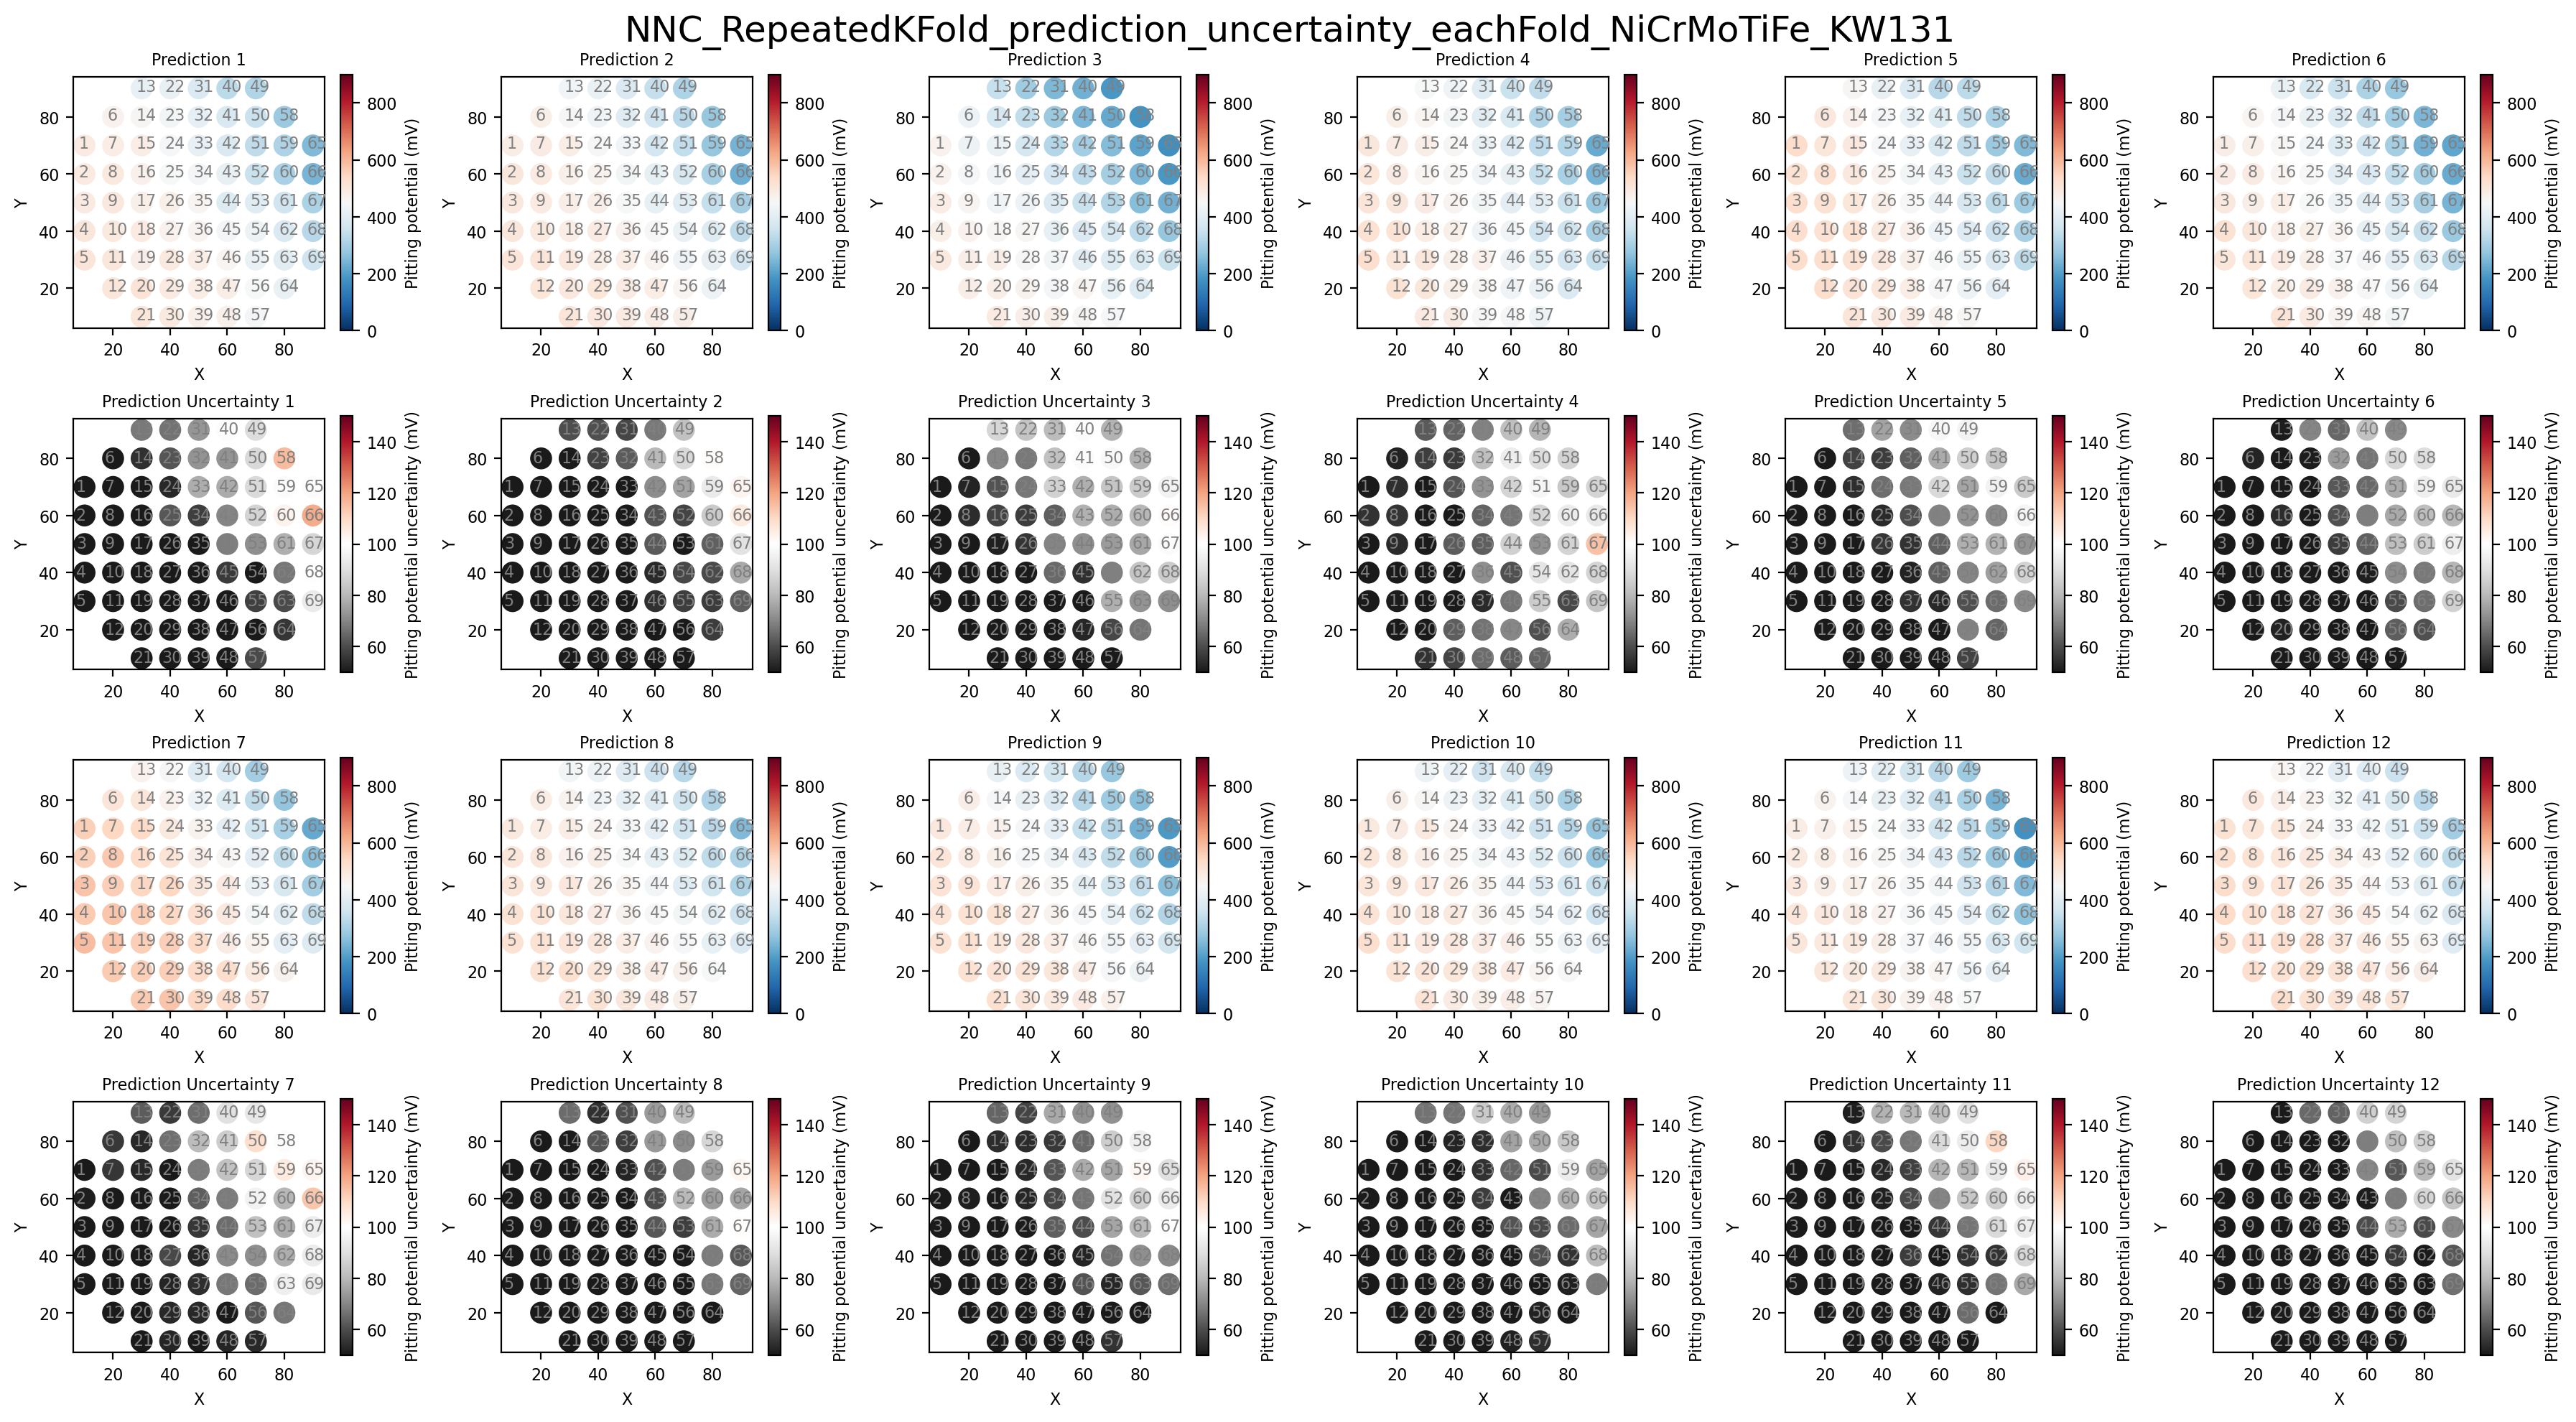

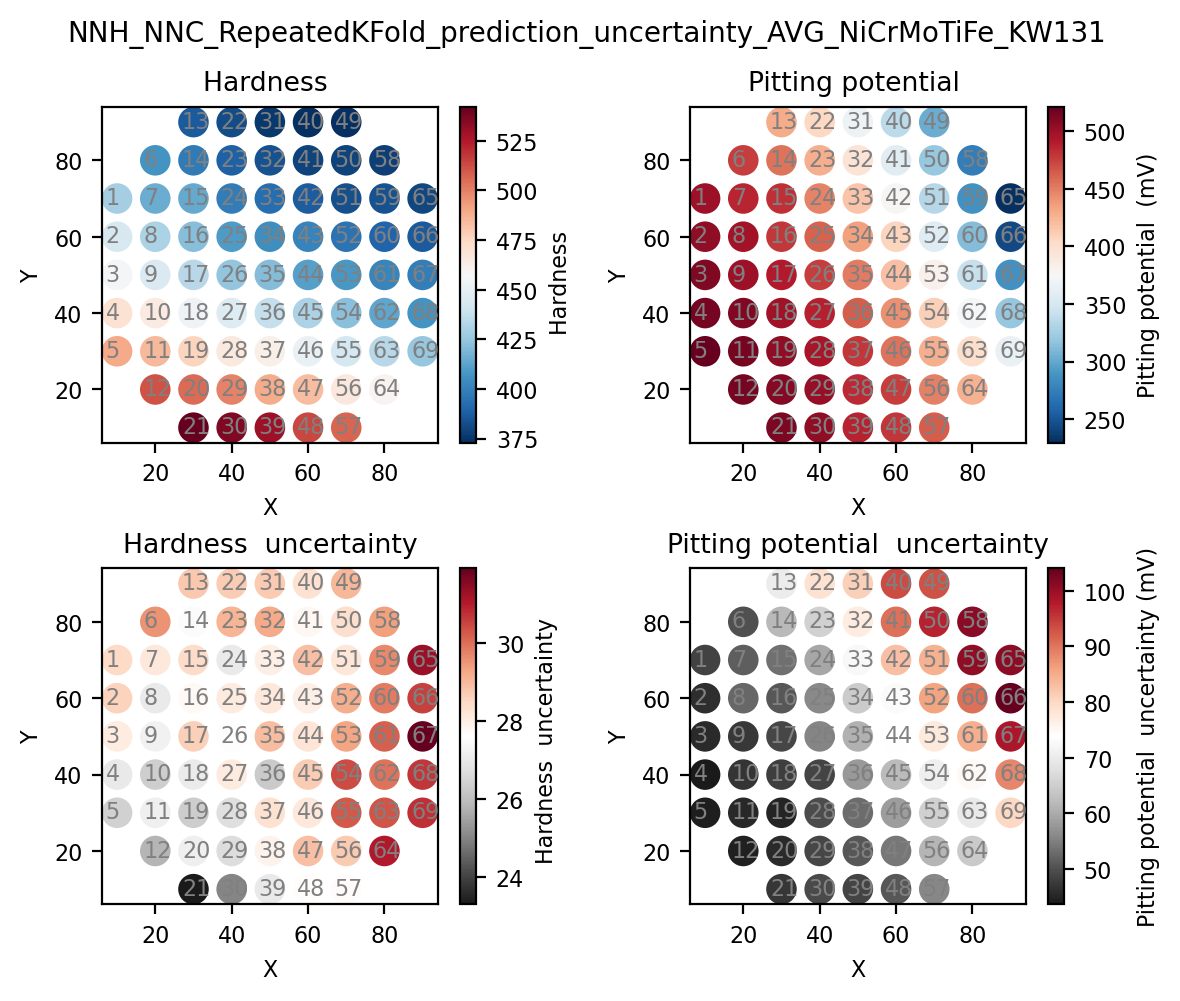

Processing: 100%|██████████| 2/2 [01:50<00:00, 55.40s/it]


In [ ]:
if Flag_Prediction:

    from utils.postprocessing_prediction import read_new_data_feature_calc, predict_bootstrap_NNH_NNC, plot_prediction_uncertainty, plot_prediction_uncertainty_AVG
    from tqdm import tqdm

    compo_A_B_C_D_E_list = [
        ['Ni', 'Cr', 'Co', 'V', 'Fe'], ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']]
    compo_A_B_C_D_E_fname_list = ['NiCrCoVFe_KW99', 'NiCrMoTiFe_KW131']

    for compo_A_B_C_D_E, compo_A_B_C_D_E_fname in tqdm(zip(compo_A_B_C_D_E_list, compo_A_B_C_D_E_fname_list), desc='Processing', total=len(compo_A_B_C_D_E_list)):

        print(compo_A_B_C_D_E)
        print(compo_A_B_C_D_E_fname)

        vars_ele = compo_A_B_C_D_E
        KW_name = compo_A_B_C_D_E_fname
        file_name_input = f'{data_path}MultiTaskModel_{KW_name}_wt_pct.xlsx'
        df_new_wt = pd.read_excel(file_name_input)

        compo_new, HC_specific_features, C_specific_testing = read_new_data_feature_calc(df_new_wt, vars_ele,
                                                                                         specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                                                                                                       'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
                                                                                         C_testing=np.array([25, 1, 7, 0.333]))

        NNH_model_name = 'NNH_model_mc_RepeatedKFold_{}.h5'
        NNC_model_name = 'NNC_model_mc_RepeatedKFold_{}.h5'
        k_folds, n_CVrepeats, mc_repeat = 6, 2, 50

        (H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std,
         C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
            model_path_bo, NNH_model_name, NNC_model_name,
            compo_new, HC_specific_features, C_specific_testing,
            scalers, k_folds, n_CVrepeats, mc_repeat)

        # Concatenate and compute mean and std + save to excel
        H1_new_pred_KFold_mean = np.mean(np.concatenate(
            H1_new_pred_stack, axis=0), axis=0).reshape(-1)
        H1_new_pred_KFold_std = np.std(np.concatenate(
            H1_new_pred_stack, axis=0), axis=0).reshape(-1)
        C2_new_pred_KFold_mean = np.mean(np.concatenate(
            C2_new_pred_stack, axis=0), axis=0).reshape(-1)
        C2_new_pred_KFold_std = np.std(np.concatenate(
            C2_new_pred_stack, axis=0), axis=0).reshape(-1)

        df_new_wt['H1_new_pred_KFold_mean'] = H1_new_pred_KFold_mean
        df_new_wt['H1_new_pred_KFold_std'] = H1_new_pred_KFold_std
        df_new_wt['C2_new_pred_KFold_mean'] = C2_new_pred_KFold_mean
        df_new_wt['C2_new_pred_KFold_std'] = C2_new_pred_KFold_std

        file_name_output = f'{model_path_bo}MultiTaskModel_{KW_name}_wt_pct_ML.xlsx'
        df_new_wt.to_excel(file_name_output, index=False)

        # NNH predictions
        plot_prediction_uncertainty(model_path_bo, coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
                                    pred_label='Hardness', unc_label='Hardness uncertainty',
                                    title='NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name,
                                    vmin1=100, vmax1=300,
                                    vmin2=25, vmax2=100)

        # NNC predictions
        plot_prediction_uncertainty(model_path_bo, coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
                                    pred_label='Pitting potential (mV)', unc_label='Pitting potential uncertainty (mV)',
                                    title='NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name,
                                    vmin1=0, vmax1=900,
                                    vmin2=50, vmax2=150)

        # NNH_NNC_AVG predictions
        plot_prediction_uncertainty_AVG(model_path_bo, coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack,
                                        title='NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name)


## Local Explanation by SHAP


### data import and processing for new data


In [ ]:
from tqdm import tqdm
from utils.postprocessing_prediction import read_new_data_feature_calc

compo_A_B_C_D_E_list = [['Ni', 'Cr', 'Co', 'V', 'Fe'],
                        ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
                        ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
                        ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
                        ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
                        ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
                        ]
compo_A_B_C_D_E_fname_list = [
    'NiCrCoVFe_KW99', 'NiCrMoTiFe_KW131', 'NiFe_CrMoTi_TC', 'NiCrFe_MoTi_TC', 'NiMoTiFe_Cr_TC', 'NiCrTiFe_Mo_TC']

for compo_A_B_C_D_E, compo_A_B_C_D_E_fname in tqdm(zip(compo_A_B_C_D_E_list, compo_A_B_C_D_E_fname_list), desc='Processing', total=len(compo_A_B_C_D_E_list)):

    print(compo_A_B_C_D_E)
    print(compo_A_B_C_D_E_fname)

    vars_ele = compo_A_B_C_D_E
    KW_name = compo_A_B_C_D_E_fname
    file_name_input = f'{data_path}MultiTaskModel_{KW_name}_wt_pct.xlsx'
    df_new_wt = pd.read_excel(file_name_input)

    compo_new, HC_specific_features, C_specific_testing = read_new_data_feature_calc(df_new_wt, vars_ele,
                                                                                     specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                                                                                                   'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
                                                                                     C_testing=np.array([25, 1, 7, 0.333]))

    if KW_name == 'NiCrCoVFe_KW99':
        KW99_compo, KW99_features, KW99_testing = compo_new, HC_specific_features, C_specific_testing
    elif KW_name == 'NiCrMoTiFe_KW131':
        KW131_compo, KW131_features, KW131_testing = compo_new, HC_specific_features, C_specific_testing
    elif KW_name == 'NiFe_CrMoTi_TC':
        NiFe_CrMoTi_TC_compo, NiFe_CrMoTi_TC_features, NiFe_CrMoTi_TC_testing = compo_new, HC_specific_features, C_specific_testing
    elif KW_name == 'NiCrFe_MoTi_TC':
        NiCrFe_MoTi_TC_compo, NiCrFe_MoTi_TC_features, NiCrFe_MoTi_TC_testing = compo_new, HC_specific_features, C_specific_testing
    elif KW_name == 'NiMoTiFe_Cr_TC':
        NiMoTiFe_Cr_TC_compo, NiMoTiFe_Cr_TC_features, NiMoTiFe_Cr_TC_testing = compo_new, HC_specific_features, C_specific_testing
    elif KW_name == 'NiCrTiFe_Mo_TC':
        NiCrTiFe_Mo_TC_compo, NiCrTiFe_Mo_TC_features, NiCrTiFe_Mo_TC_testing = compo_new, HC_specific_features, C_specific_testing

index_KW99_FCC = [x for x in list(range(0, 64)) if x not in [
    20, 29, 38, 47, 56]]
# index_KW131_FCC = [0, 1, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26,
#                    30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 48, 49, 50, 51, 52, 53, 54]
index_KW131_FCC = np.arange(69)

# the reference dataset: for hardness model and corrosion model
# X1_base_data, Y1_base_data, V1_base_data = np.vstack(
#     (NiCrTiFe_Mo_TC_compo)), np.empty(0), np.vstack((NiCrTiFe_Mo_TC_features))
# X2_base_data, Z2_base_data, W2_base_data = np.vstack((NiCrTiFe_Mo_TC_compo)), np.vstack(
#     (NiCrTiFe_Mo_TC_testing)), np.vstack((NiCrTiFe_Mo_TC_features))


X1_base_data, Y1_base_data, V1_base_data = np.vstack(
    (KW131_compo[index_KW131_FCC, :])), np.empty(0), np.vstack((KW131_features[index_KW131_FCC, :]))
X2_base_data, Z2_base_data, W2_base_data = np.vstack(
    (KW131_compo[index_KW131_FCC, :])), np.vstack((KW131_testing[index_KW131_FCC, :])), np.vstack((KW131_features[index_KW131_FCC, :]))


# the shap analysis dataset: for hardness model and corrosion model
X1_shap_data, Y1_shap_data, V1_shap_data = np.vstack(
    (KW131_compo[index_KW131_FCC, :])), np.empty(0), np.vstack((KW131_features[index_KW131_FCC, :]))
X2_shap_data, Z2_shap_data, W2_shap_data = np.vstack(
    (KW131_compo[index_KW131_FCC, :])), np.vstack((KW131_testing[index_KW131_FCC, :])), np.vstack((KW131_features[index_KW131_FCC, :]))

print(X1_base_data.shape, Y1_base_data.shape, V1_base_data.shape)
print(X2_base_data.shape, Z2_base_data.shape, W2_base_data.shape)

print(X1_shap_data.shape, Y1_shap_data.shape, V1_shap_data.shape)
print(X2_shap_data.shape, Z2_shap_data.shape, W2_shap_data.shape)

# print(len(Y1_shap_data))
# print(len(V1_shap_data))

# print(Z2_base_data)
# print(Z2_base_data)

print(X1_shap_data.shape)

Processing:  17%|█▋        | 1/6 [00:00<00:00,  5.30it/s]

['Ni', 'Cr', 'Co', 'V', 'Fe']
NiCrCoVFe_KW99
['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiCrMoTiFe_KW131


Processing:  33%|███▎      | 2/6 [00:00<00:00,  4.25it/s]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiFe_CrMoTi_TC


Processing:  50%|█████     | 3/6 [00:00<00:00,  4.21it/s]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiCrFe_MoTi_TC


Processing:  67%|██████▋   | 4/6 [00:00<00:00,  4.24it/s]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiMoTiFe_Cr_TC


Processing:  83%|████████▎ | 5/6 [00:01<00:00,  3.40it/s]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiCrTiFe_Mo_TC


Processing: 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

(69, 20) (0,) (69, 8)
(69, 20) (69, 4) (69, 8)
(69, 20) (0,) (69, 8)
(69, 20) (69, 4) (69, 8)
(69, 20)


### model prediction and SHAP analysis


In [ ]:
from utils.postprocessing_shap import predict_norm_shap_bootstrap

NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}.h5', 'NNC_model_RepeatedKFold_{}.h5'
k_folds, n_CVrepeats, mc_repeat = 6, 2, 1

repeat_val = k_folds * n_CVrepeats

X1_base_list, Y1_base_list, V1_base_list = [
    X1_base_data]*repeat_val, [], [V1_base_data]*repeat_val
X2_base_list, Z2_base_list, W2_base_list = [
    X2_base_data]*repeat_val, [Z2_base_data]*repeat_val, [W2_base_data]*repeat_val

X1_shap_list, Y1_shap_list, V1_shap_list = [
    X1_shap_data]*repeat_val, [], [V1_shap_data]*repeat_val
X2_shap_list, Z2_shap_list, W2_shap_list = [
    X2_shap_data]*repeat_val, [Z2_shap_data]*repeat_val, [W2_shap_data]*repeat_val

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(predict_norm_shap_bootstrap, model_path_bo, NNH_model_name,
                              X1_base_list, Y1_base_list, V1_base_list,
                              X1_shap_list, Y1_shap_list, V1_shap_list,
                              k_folds, n_CVrepeats, mc_repeat,
                              scalers["compo"], [], scalers["specific_features"])

    future2 = executor.submit(predict_norm_shap_bootstrap, model_path_bo, NNC_model_name,
                              X2_base_list, Z2_base_list, W2_base_list,
                              X2_shap_list, Z2_shap_list, W2_shap_list,
                              k_folds, n_CVrepeats, mc_repeat,
                              scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"])

(H1_pred_norm_X1_base_stack, _, _,
 H1_pred_norm_X1_shap_stack, _, _, H1_shap_X1_stack) = future1.result()
(C2_pred_norm_X2_base_stack, _, _,
 C2_pred_norm_X2_shap_stack, _, _, C2_shap_X2_stack) = future2.result()

# print(C2_pred_norm_X2_base_stack[0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

In [ ]:
from utils.postprocessing_shap import process_predict_norm_shap_data

(H1_pred_norm_X1_base_KFold_mean, _,
 H1_pred_norm_X1_shap_KFold_mean, _, H1_shap_X1_KFold_mean, _) = process_predict_norm_shap_data(
    H1_pred_norm_X1_base_stack, H1_pred_norm_X1_shap_stack, H1_shap_X1_stack)

print(H1_pred_norm_X1_base_KFold_mean.shape)
print(H1_pred_norm_X1_shap_KFold_mean.shape)
print(H1_shap_X1_KFold_mean.shape)

(C2_pred_norm_X2_base_KFold_mean, _,
 C2_pred_norm_X2_shap_KFold_mean, _, C2_shap_X2_KFold_mean, _) = process_predict_norm_shap_data(
    C2_pred_norm_X2_base_stack, C2_pred_norm_X2_shap_stack, C2_shap_X2_stack)

print(C2_pred_norm_X2_base_KFold_mean.shape)
print(C2_pred_norm_X2_shap_KFold_mean.shape)
print(C2_shap_X2_KFold_mean.shape)


print(C2_pred_norm_X2_base_stack[0].reshape(-1).shape)
print(C2_pred_norm_X2_shap_stack[0].reshape(-1).shape)
print(C2_shap_X2_stack[0].shape)


(69,)
(69,)
(69, 28)
(69,)
(69,)
(69, 32)
(69,)
(69,)
(69, 32)


shapley value          feature
0        0.017289               Fe
1       -0.001098               Cr
2       -0.005100               Ni
3       -0.001192               Mo
4        0.000000                W
5        0.000000                N
6        0.000000               Nb
7        0.000000                C
8        0.000000               Si
9        0.000000               Mn
10       0.000000               Cu
11       0.000000               Al
12       0.000000                V
13       0.000000               Ta
14      -0.001352               Ti
15       0.000000               Co
16       0.000000               Mg
17       0.000000                Y
18       0.000000               Zr
19       0.000000               Hf
20      -0.004057          delta_a
21      -0.000854               Tm
22       0.000987         sigma_Tm
23      -0.000511             Hmix
24      -0.001110       sigma_Hmix
25       0.001425  sigma_elec_nega
26       0.002232              VEC
27       0.002275        sigma_VEC

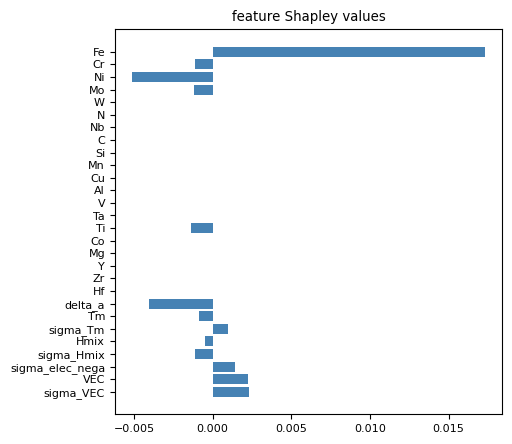

In [ ]:

shap_values_df = pd.DataFrame(
    data={'shapley value': H1_shap_X1_stack[0][0, :], 'feature': compo_column + specific_features_sel_column})
display(shap_values_df)

plt.figure(figsize=(5, 5))
plt.barh(y=shap_values_df['feature'],
         width=shap_values_df['shapley value'], color='steelblue')
plt.title("feature Shapley values")

plt.gca().invert_yaxis()

In [ ]:
import shap
from utils.postprocessing_shap import plot_shap_force

# A, B, C = plot_shap_force(X1_shap_data, [], V1_shap_data,
#                           compo_column, C_specific_testing_column, specific_features_sel_column,
#                           H1_pred_norm_X1_base_KFold_mean, H1_pred_norm_X1_shap_KFold_mean, H1_shap_X1_KFold_mean,
#                           sample_index=np.arange(69))

# sample_index = [12, 19, 27, 35, 43, 51, 58]
sample_index = [5, 11, 19, 28, 37, 46, 55, 63, 69]
sample_index = [x-1 for x in sample_index]
A, B, C = plot_shap_force(X2_shap_data, Z2_shap_data, W2_shap_data,
                          compo_column, C_specific_testing_column, specific_features_sel_column,
                          C2_pred_norm_X2_base_KFold_mean, C2_pred_norm_X2_shap_KFold_mean, C2_shap_X2_KFold_mean,
                          sample_index=sample_index)

shap.initjs()
shap.force_plot(
    A,
    B,
    C,
    link='identity',
    matplotlib=False,
    figsize=(25, 3),
    text_rotation=45,
    contribution_threshold=0.001
)


(69, 32)


Fe         Cr         Ni         Mo    W    N   Nb    C   Si   Mn  \
0  16.721686  34.359633  32.018063  13.075895  0.0  0.0  0.0  0.0  0.0  0.0   
1  21.059316  29.321882  33.809362  11.335062  0.0  0.0  0.0  0.0  0.0  0.0   
2  26.195882  23.850422  34.948388  10.213022  0.0  0.0  0.0  0.0  0.0  0.0   
3  31.742036  19.341372  35.299463   8.488290  0.0  0.0  0.0  0.0  0.0  0.0   
4  37.895287  15.018106  34.007115   7.695502  0.0  0.0  0.0  0.0  0.0  0.0   
5  44.975842  11.263842  32.094284   6.302047  0.0  0.0  0.0  0.0  0.0  0.0   
6  51.372761   8.790516  29.881651   4.817071  0.0  0.0  0.0  0.0  0.0  0.0   
7  57.332368   6.626917  27.032941   4.283869  0.0  0.0  0.0  0.0  0.0  0.0   
8  63.370312   5.076982  23.439965   4.034033  0.0  0.0  0.0  0.0  0.0  0.0   

   ...   pH  ScanRate_mVs   delta_a           Tm    sigma_Tm      Hmix  \
0  ...  7.0         0.333  0.042356  2018.214448  324.730878 -8.088070   
1  ...  7.0         0.333  0.043881  1984.893645  312.791253 -8.544523   
2  ...  7.0         0.333  0.044612  1954.568006  302.132994 -8.660220   
3  ...  7.0         0.333  0.045092  1924.534455  282.189438 -8.668713   
4  ...  7.0         0.333  0.045715  1903.055727  267.955518 -8.499984   
5  ...  7.0         0.333  0.045192  1879.925142  244.231960 -8.024936   
6  ...  7.0         0.333  0.043864  1861.438763  217.399299 -7.404816   
7  ...  7.0         0.333  0.042262  1850.859046  202.320060 -6.655099   
8  ...  7.0         0.333  0.039801  1844.869218  192.175144 -5.701689   

   sigma_Hmix  sigma_elec_nega       VEC  sigma_VEC  
0    4.408553         0.157790  7.522191   1.906035  
1    4.828722         0.151885  7.661043   1.913480  
2    5.066392         0.145735  7.803527   1.889767  
3    5.222827         0.137981  7.915606   1.850493  
4    5.257125         0.131770  7.983231   1.793112  
5    5.108180         0.122778  8.046247   1.709770  
6    4.855417         0.113546  8.085638   1.621859  
7    4.517802         0.106104  8.103650   1.525445  
8    4.064609         0.098628  8.101491   1.410874  

[9 rows x 32 columns]

Pred calculated from model: [0.5750496  0.5726258  0.56982666 0.5657082  0.561262   0.553465
 0.5419914  0.528217   0.5111858 ]


Fe        Cr        Ni        Mo    W    N   Nb    C   Si   Mn  ...  \
0  0.004063  0.008499  0.000331  0.002038  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1  0.004090  0.007080  0.000378  0.001712  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2  0.003894  0.005277  0.000412  0.001549  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3  0.003375  0.003599  0.000454  0.001172  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4  0.002327  0.001626  0.000444  0.001020  0.0  0.0  0.0  0.0  0.0  0.0  ...   
5  0.000295 -0.000689  0.000417  0.000648  0.0  0.0  0.0  0.0  0.0  0.0  ...   
6 -0.002943 -0.002883  0.000283  0.000101  0.0  0.0  0.0  0.0  0.0  0.0  ...   
7 -0.007365 -0.005473 -0.000028 -0.000178  0.0  0.0  0.0  0.0  0.0  0.0  ...   
8 -0.012687 -0.008004 -0.000690 -0.000367  0.0  0.0  0.0  0.0  0.0  0.0  ...   

         pH  ScanRate_mVs   delta_a        Tm  sigma_Tm      Hmix  sigma_Hmix  \
0  0.006599     -0.000252 -0.000576  0.006674 -0.000569  0.004218         0.0   
1  0.006325     -0.000354 -0.000944  0.006275 -0.000393  0.004501         0.0   
2  0.006167     -0.000343 -0.001222  0.005912 -0.000229  0.004563         0.0   
3  0.005383     -0.000259 -0.001484  0.005316 -0.000145  0.004525         0.0   
4  0.004821     -0.000112 -0.001663  0.004882 -0.000099  0.004103         0.0   
5  0.003268      0.000103 -0.001704  0.003896 -0.000044  0.003200         0.0   
6  0.000659      0.000286 -0.001589  0.002198 -0.000015  0.001760         0.0   
7 -0.001446      0.000367 -0.001207  0.000158 -0.000022 -0.000685         0.0   
8 -0.003381      0.000336 -0.000527 -0.002542 -0.000065 -0.004399         0.0   

   sigma_elec_nega  VEC  sigma_VEC  
0              0.0  0.0        0.0  
1              0.0  0.0        0.0  
2              0.0  0.0        0.0  
3              0.0  0.0        0.0  
4              0.0  0.0        0.0  
5              0.0  0.0        0.0  
6              0.0  0.0        0.0  
7              0.0  0.0        0.0  
8              0.0  0.0        0.0  

[9 rows x 32 columns]

Validate the pred calculated using SHAP values:  [0.57504954 0.57262578 0.56982666 0.56570823 0.56126197 0.55346497
 0.5419914  0.52821697 0.51118576]
0.5412281
(9, 32)


In [ ]:
print(H1_shap_X1_KFold_mean.shape)


(69, 28)


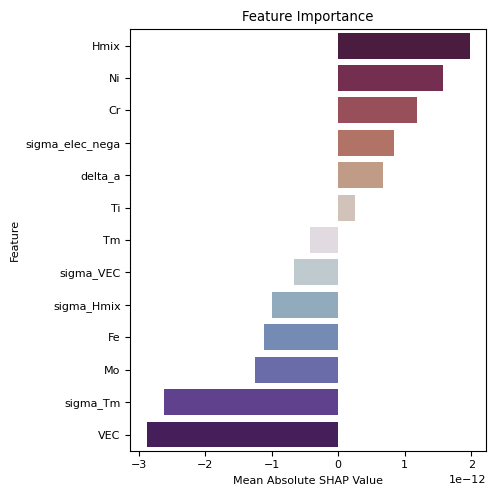

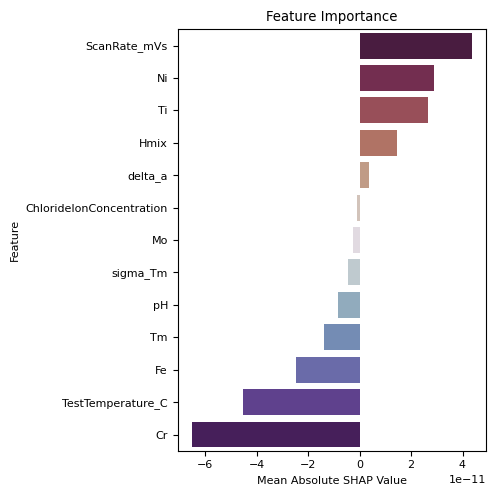

In [ ]:
from utils.postprocessing_shap import plot_shap_summary

# shap summary plot:
plot_shap_summary(H1_shap_X1_KFold_mean, compo_column + specific_features_sel_column,
                  title='Feature Importance', figsize=(5, 5), palette='twilight_shifted_r')

plot_shap_summary(C2_shap_X2_KFold_mean, compo_column + C_specific_testing_column + specific_features_sel_column,
                  title='Feature Importance', figsize=(5, 5), palette='twilight_shifted_r')

In [ ]:
from utils.path_explainer_tf import PathExplainerTF
from utils.utils import softplus_activation

model = keras.models.load_model(os.path.join(
    model_path_bo, NNH_model_name.format(0+1)))

interpret_model = tf.keras.models.clone_model(model)
interpret_model.set_weights(model.get_weights())

# # Loop through layers to change activation functions
# for layer in interpret_model.layers:
#     if hasattr(layer, 'activation'):
#         layer.activation = softplus_activation(beta=10.0)


2023-09-05 21:42:17.332245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-05 21:42:17.332284: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-05 21:42:17.332315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws14): /proc/driver/nvidia/version does not exist
2023-09-05 21:42:17.332613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
explainer = PathExplainerTF(interpret_model)

X1_base_normalized = scalers["compo"].transform(X1_base_data)
V1_base_normalized = scalers["specific_features"].transform(V1_base_data)
model_input_norm = np.concatenate(
    [X1_base_normalized, V1_base_normalized], axis=1)

print(model_input_norm.shape)

(69, 28)


In [ ]:
attributions = explainer.attributions(inputs=model_input_norm.astype(np.float32),
                                      baseline=model_input_norm.astype(
                                          np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)


100%|██████████| 69/69 [00:01<00:00, 42.84it/s]


(69, 28)


attributions value          feature
0             0.017511               Fe
1            -0.000836               Cr
2            -0.005346               Ni
3            -0.001350               Mo
4             0.000000                W
5             0.000000                N
6             0.000000               Nb
7             0.000000                C
8             0.000000               Si
9             0.000000               Mn
10            0.000000               Cu
11            0.000000               Al
12            0.000000                V
13            0.000000               Ta
14           -0.001488               Ti
15            0.000000               Co
16            0.000000               Mg
17            0.000000                Y
18            0.000000               Zr
19            0.000000               Hf
20           -0.004348          delta_a
21           -0.000796               Tm
22            0.000855         sigma_Tm
23           -0.000967             Hmix
24           -0.001128       sigma_Hmix
25            0.001246  sigma_elec_nega
26            0.001609              VEC
27            0.001932        sigma_VEC

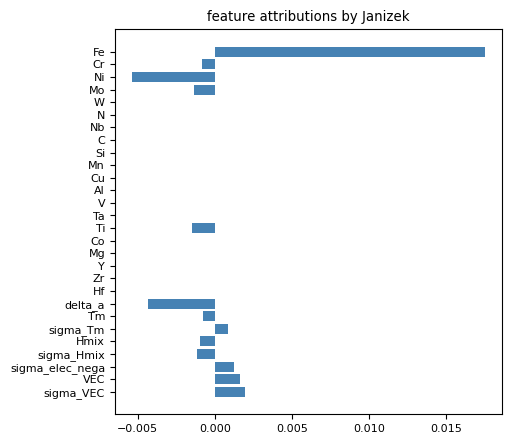

In [ ]:
print(attributions.shape)
attributions_df = pd.DataFrame(
    data={'attributions value': attributions[0, :], 'feature': compo_column + specific_features_sel_column})
display(attributions_df)

plt.figure(figsize=(5, 5))
plt.barh(y=attributions_df['feature'],
         width=attributions_df['attributions value'], color='steelblue')
plt.title("feature attributions by Janizek")
plt.gca().invert_yaxis()

In [ ]:
shap_explainer = shap.DeepExplainer(model, model_input_norm)
shap_values_all = shap_explainer.shap_values(model_input_norm)


(69, 28)


shapley value          feature
0        0.017289               Fe
1       -0.001098               Cr
2       -0.005100               Ni
3       -0.001192               Mo
4        0.000000                W
5        0.000000                N
6        0.000000               Nb
7        0.000000                C
8        0.000000               Si
9        0.000000               Mn
10       0.000000               Cu
11       0.000000               Al
12       0.000000                V
13       0.000000               Ta
14      -0.001352               Ti
15       0.000000               Co
16       0.000000               Mg
17       0.000000                Y
18       0.000000               Zr
19       0.000000               Hf
20      -0.004057          delta_a
21      -0.000854               Tm
22       0.000987         sigma_Tm
23      -0.000511             Hmix
24      -0.001110       sigma_Hmix
25       0.001425  sigma_elec_nega
26       0.002232              VEC
27       0.002275        sigma_VEC

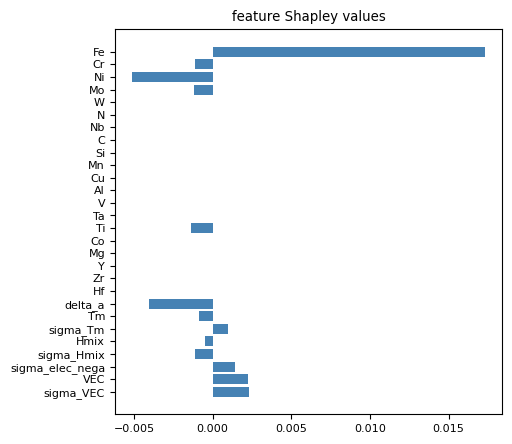

In [ ]:
print(shap_values_all[0].shape)

shap_values_df = pd.DataFrame(
    data={'shapley value': shap_values_all[0][0, :], 'feature': compo_column + specific_features_sel_column})
display(shap_values_df)

plt.figure(figsize=(5, 5))
plt.barh(y=shap_values_df['feature'],
         width=shap_values_df['shapley value'], color='steelblue')
plt.title("feature Shapley values")

plt.gca().invert_yaxis()

In [ ]:
interactions = explainer.interactions(inputs=model_input_norm.astype(np.float32),
                                      baseline=model_input_norm.astype(
                                          np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)


100%|██████████| 69/69 [00:58<00:00,  1.17it/s]


(69, 28, 28)
(28, 28)
(28, 28)


Text(0.5, 1.0, 'Correlation matrix of the features')

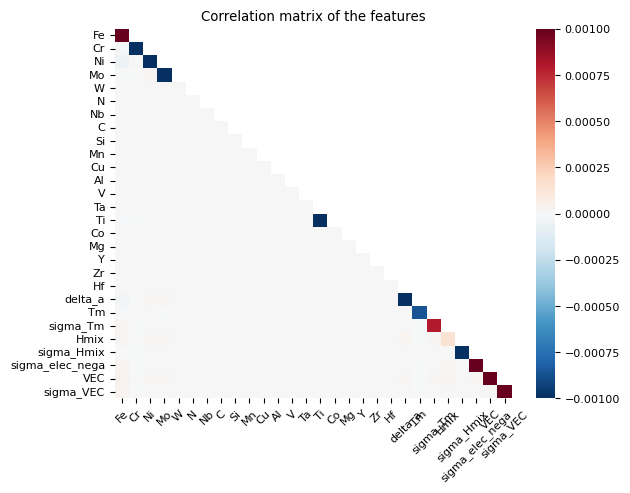

In [ ]:
print(interactions.shape)
print(interactions[0].shape)

average_interactions = interactions[0, :, :]
# average_interactions = np.mean(interactions, axis=0)

print(average_interactions.shape)

# Create a mask with True in all the cells. We'll only set the diagonal to False in the next step.
mask = np.triu(np.ones_like(average_interactions, dtype=bool))

# Set the diagonal to False (these are the cells we want to keep)
np.fill_diagonal(mask, False)

ax = sns.heatmap(average_interactions, mask=mask, annot=False, fmt=".2f", cmap='RdBu_r', vmax=0.001, vmin=-0.001,
                 xticklabels=compo_column + specific_features_sel_column,
                 yticklabels=compo_column + specific_features_sel_column)
ax.tick_params(axis='x', labelrotation=45)
plt.title("Correlation matrix of the features")
